In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

In [36]:
df = pd.read_csv('final_combined_dataset.csv')


In [37]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())

# df["cases_rolling_mean"] = df.groupby("geocode")["cases"].transform(lambda x: x.rolling(4).mean())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1,-2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[3,4])
data = data.dropna().reset_index(drop=True)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse_output=False), ['geocode'])  # One-hot encode 'geocode'
], remainder='passthrough')  # Keep all other columns as is

transformed_data = ct.fit_transform(data)

# Get feature names
feature_names = ct.get_feature_names_out()

# Clean feature names to remove 'remainder__' prefix
cleaned_feature_names = [name.split('__')[-1] if 'remainder__' in name else name for name in feature_names]

# Convert transformed data back to DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=cleaned_feature_names)

numeric_cols = data.select_dtypes(include=['float64', 'int64','int32']).columns
for col in numeric_cols:
    if col in transformed_df.columns:
        transformed_df[col] = pd.to_numeric(transformed_df[col], errors='coerce')

if 'date' in transformed_df.columns:
    transformed_df['date'] = pd.to_datetime(transformed_df['date'], errors='coerce')

data= transformed_df

# Now 'transformed_df' contains the transformed data with the correct types
train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]
pd.set_option('display.max_columns', None)
train_data.info

<bound method DataFrame.info of       onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51581                     0.0                     0.0                     0.0   
51582                     0.0                     0.0                     0.0   
51583                     0.0                     0.0                     0.0   
51584                     0.0                     0.0                     0.0   
51585                     0.0                     0.0                     0.0

In [38]:
X_train = train_data.drop(columns=['cases','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_lag-2'])
y_test = test_data[['cases_lag-2']]

data = data.drop(columns=['cases_per_100k'])

data

onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300308 onehot__geocode_3300407 onehot__geocode_3300456  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300506 onehot__geocode_3300605 onehot__geocode_3300704  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300803 onehot__geocode_3300902 onehot__geocode_3300936  \
0                         0.0    

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV

# Step 1-6: Keep the previous preprocessing steps the same (data preparation, scaling, etc.)
columns_not_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] + [col for col in data.columns if col.startswith('onehot__geocode_')]

feature_cols = [
    'cases_lag0', 'cases_lag1',
    'temp_avg', 'humidity_avg',
    'precipitation_avg_ordinary_kriging_lag3',
    'precipitation_avg_ordinary_kriging_lag4',
    'week_sin', 'month_sin', 'week_cos', 'month_cos',
    'week','cases_per_100k','vim'
]


selected_columns = feature_cols + [col for col in data.columns if col.startswith('onehot_')]

X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and col not in columns_not_to_scale]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

X_train

cases_lag0  cases_lag1  temp_avg  humidity_avg  \
0        0.002448    0.002244  0.744210      0.076346   
1        0.002652    0.002448  0.857288      0.030776   
2        0.002516    0.002652  0.735651      0.112676   
3        0.002244    0.002516  0.798631      0.079875   
4        0.003128    0.002244  0.869694      0.032421   
...           ...         ...       ...           ...   
51581    0.000204    0.000068  0.637623      0.265076   
51582    0.000068    0.000204  0.629001      0.276969   
51583    0.000000    0.000068  0.650046      0.280812   
51584    0.000136    0.000000  0.741926      0.247515   
51585    0.000000    0.000136  0.688998      0.290854   

       precipitation_avg_ordinary_kriging_lag3  \
0                                     0.354975   
1                                     0.179205   
2                                     0.134402   
3                                     0.245891   
4                                     0.332778   
...                                        ...   
51581                                 0.493605   
51582                                 0.363258   
51583                                 0.133155   
51584                                 0.325751   
51585                                 0.554764   

       precipitation_avg_ordinary_kriging_lag4  week_sin     month_sin  \
0                                     0.495235  0.885456  5.000000e-01   
1                                     0.354975  0.822984  8.660254e-01   
2                                     0.179205  0.748511  8.660254e-01   
3                                     0.134402  0.663123  8.660254e-01   
4                                     0.245891  0.568065  8.660254e-01   
...                                        ...       ...           ...   
51581                                 0.089023 -0.354605 -5.000000e-01   
51582                                 0.493605 -0.464723 -2.449294e-16   
51583                                 0.363258 -0.568065 -2.449294e-16   
51584                                 0.133155 -0.663123 -2.449294e-16   
51585                                 0.325751 -0.748511 -2.449294e-16   

       week_cos  month_cos    week  cases_per_100k       vim  \
0     -0.464723   0.866025  201205        0.008014  0.963737   
1     -0.568065   0.500000  201206        0.008682  0.965570   
2     -0.663123   0.500000  201207        0.008237  0.967314   
3     -0.748511   0.500000  201208        0.007346  0.968765   
4     -0.822984   0.500000  201209        0.010240  0.970280   
...         ...        ...     ...             ...       ...   
51581 -0.935016   0.866025  202049        0.000505  0.682952   
51582 -0.885456   1.000000  202050        0.000168  0.698030   
51583 -0.822984   1.000000  202051        0.000000  0.709180   
51584 -0.748511   1.000000  202052        0.000336  0.718140   
51585 -0.663123   1.000000  202053        0.000000  0.727981   

      onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51581                     0.0                     0.0                     0.0   
51582                     0.0                     0.0                     0.0   
51583                     0.0                     0.0                     0.0   
51584                     0.0                     0.0                     0.0   
51585                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0        

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Train RMSE: 45.95377292004474
Test RMSE: 5.702907686042055
Train R²: 0.960391449559934
Test R²: 0.8670823312348277
Mean Absolute Error (MAE): 1.6478393130178661
Mean Absolute Percentage Error (MAPE): 1.6229844178681114e+17 %


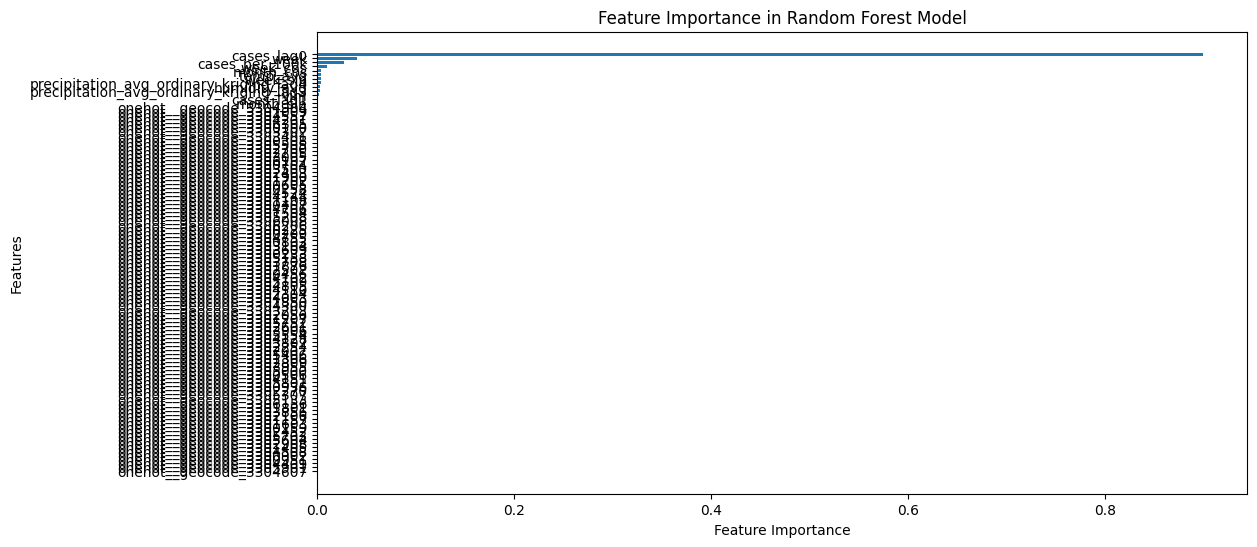

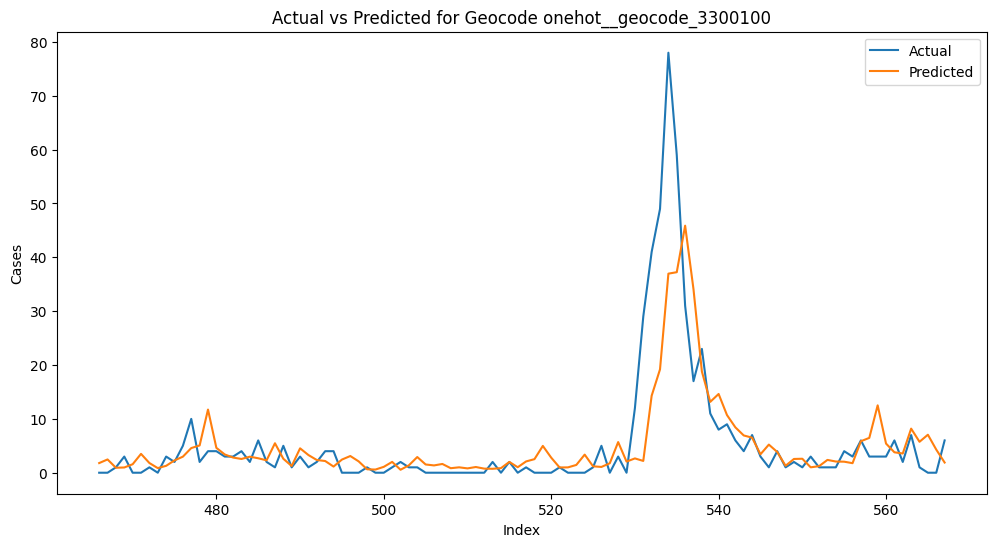

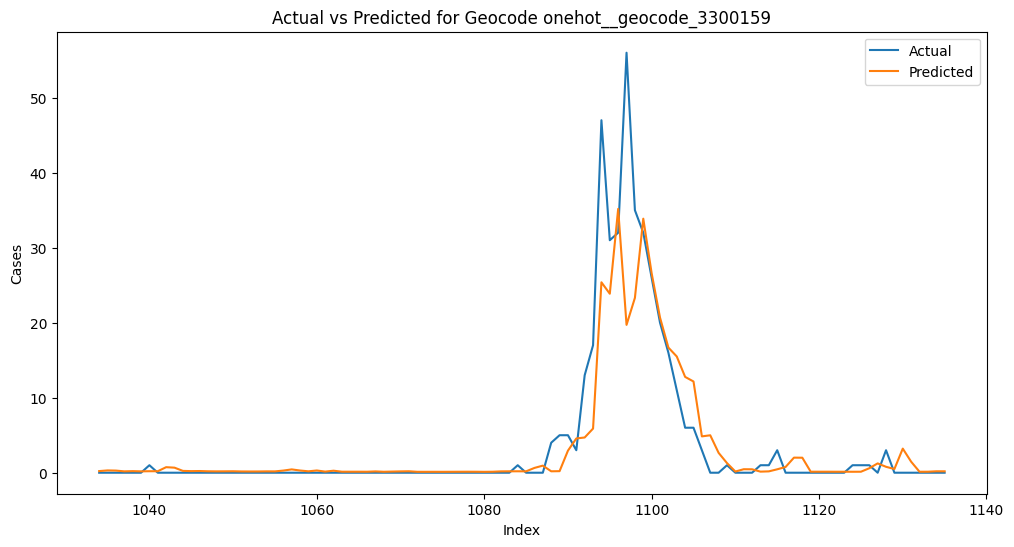

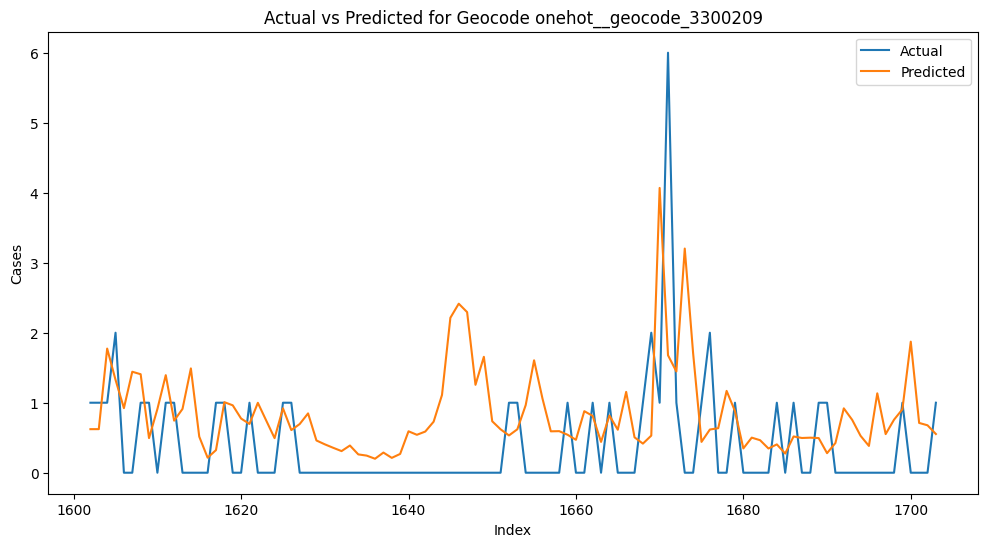

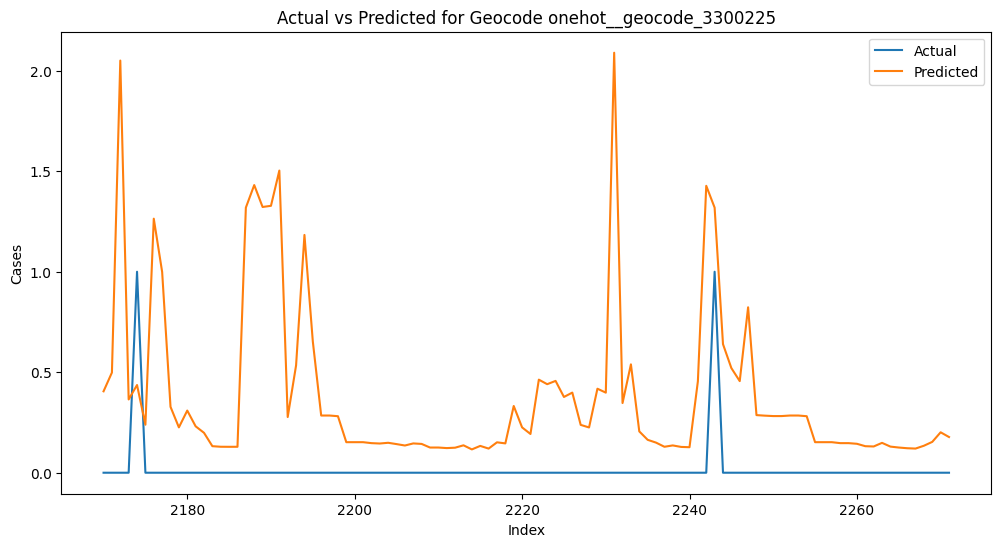

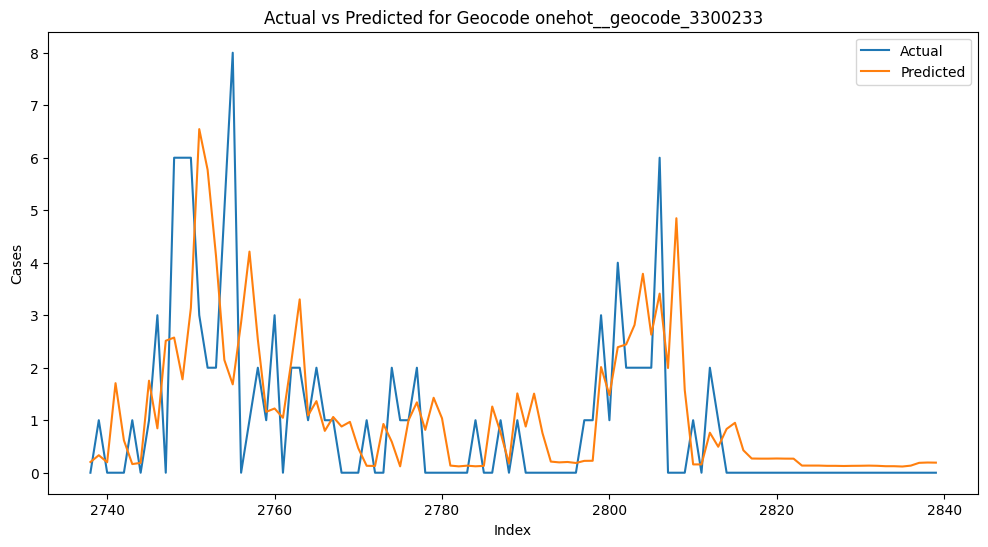

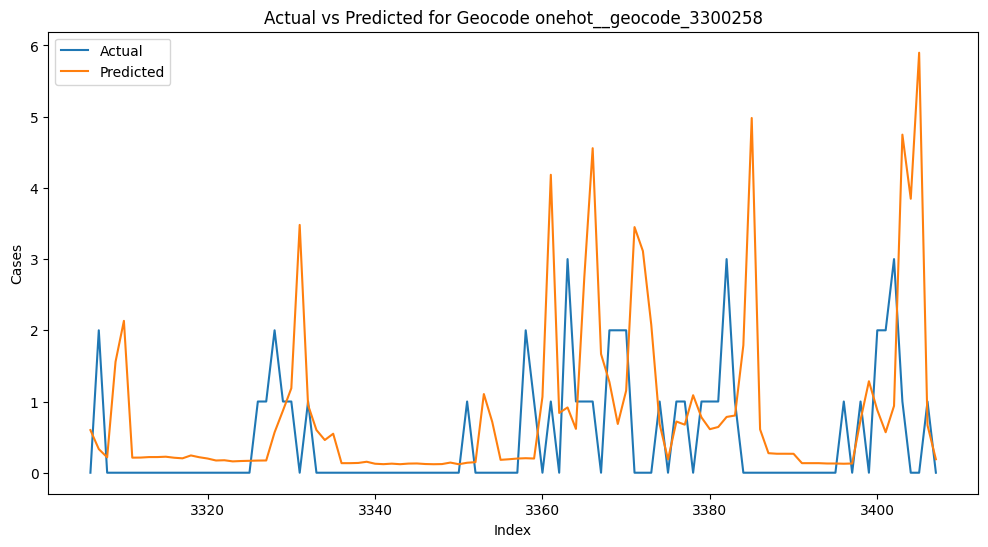

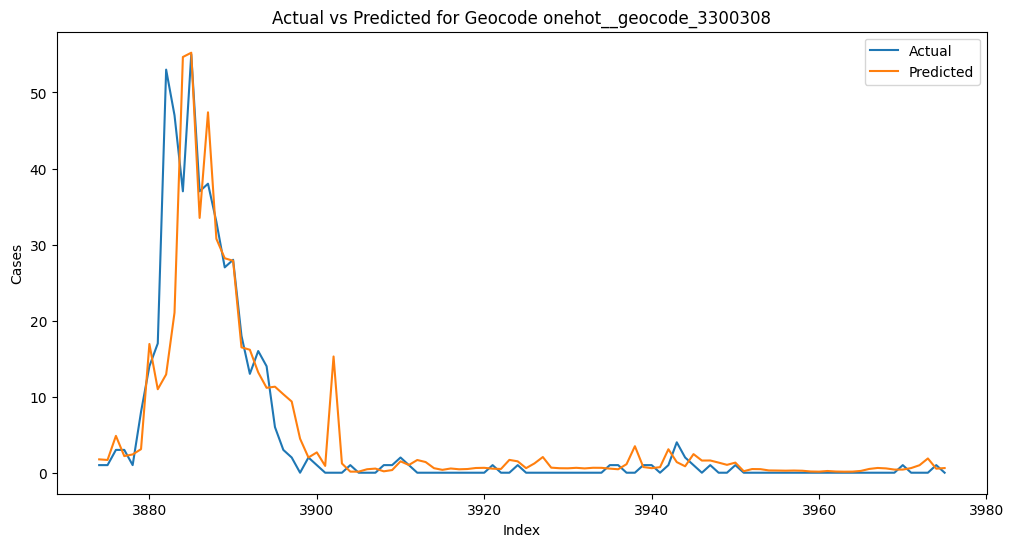

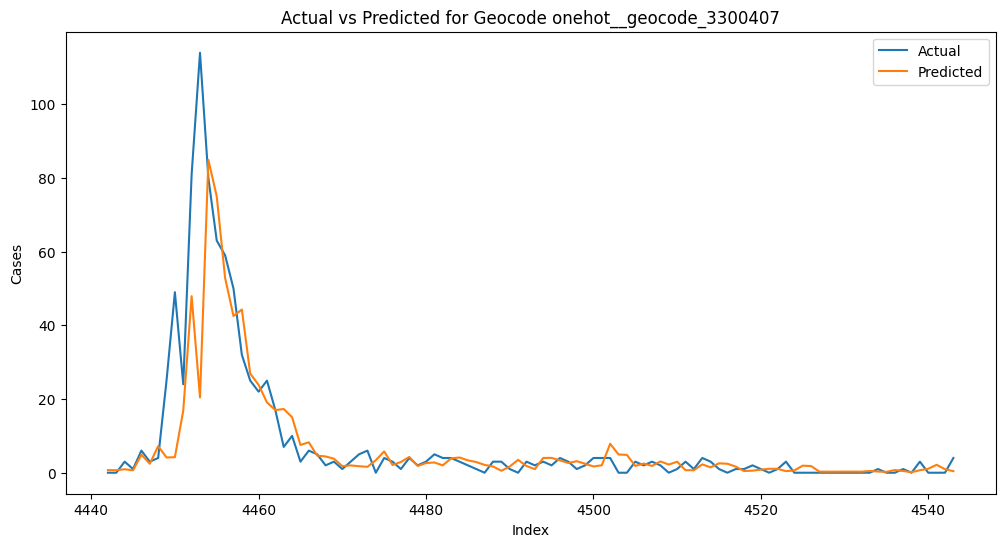

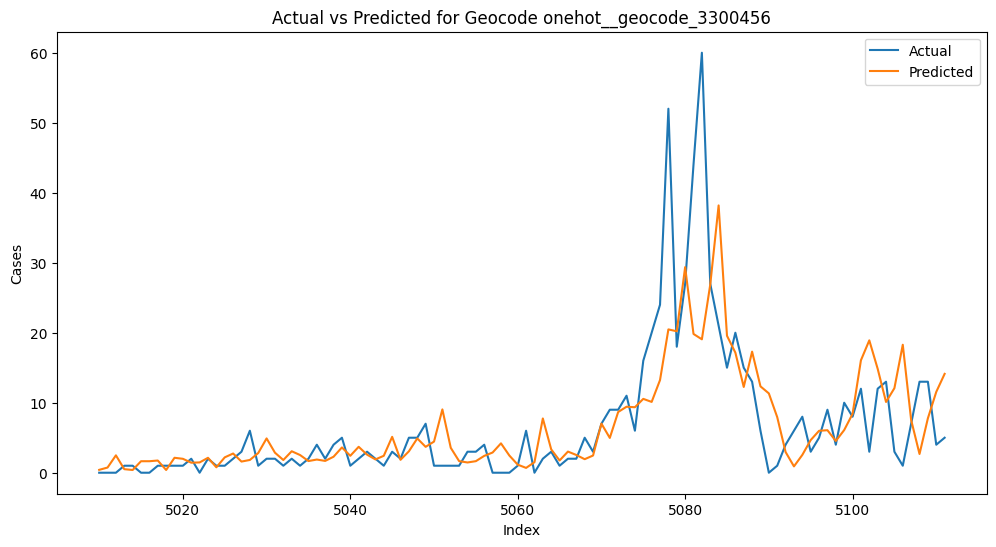

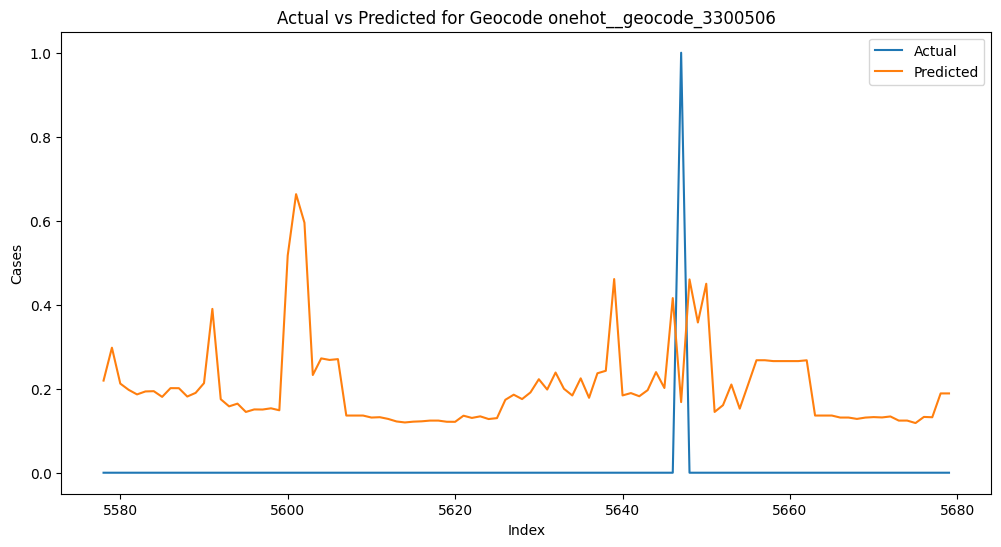

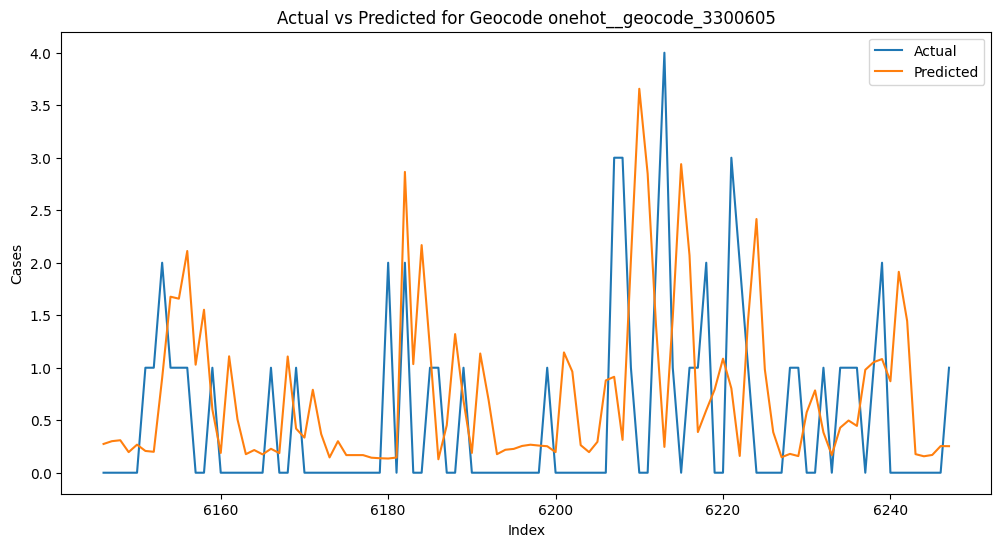

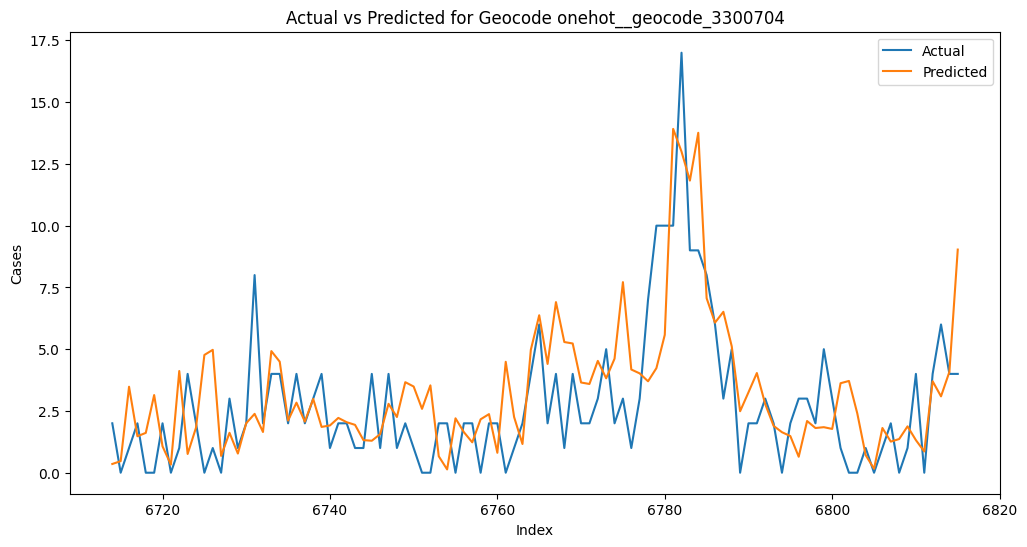

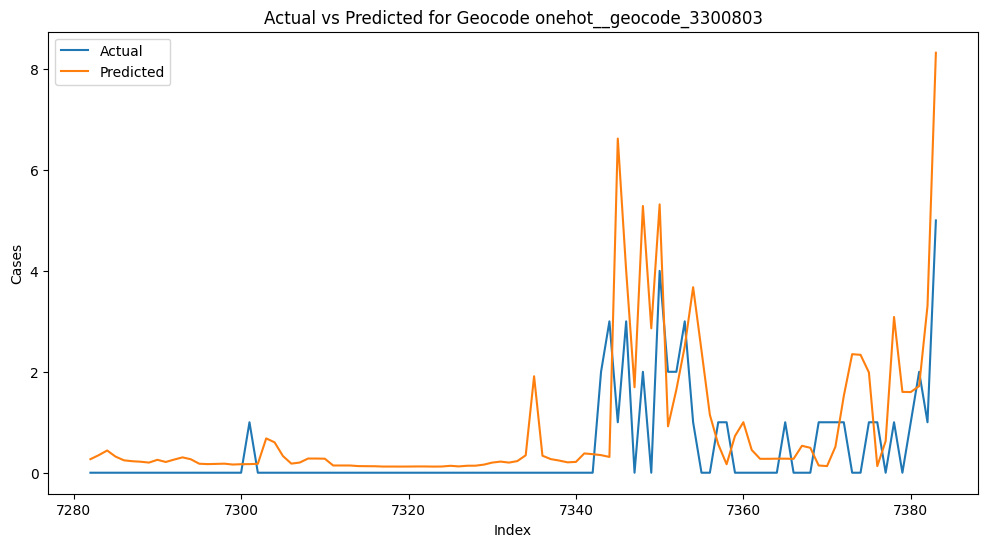

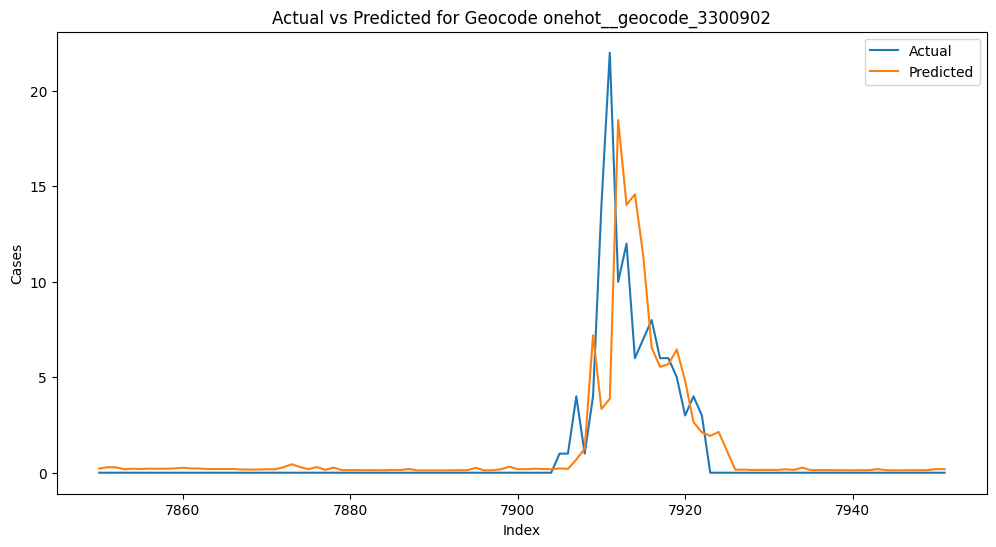

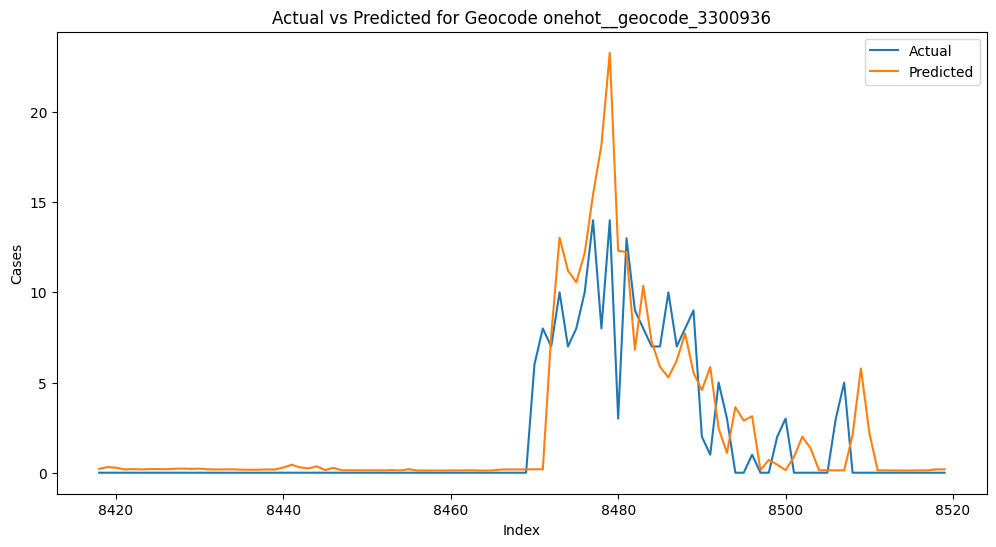

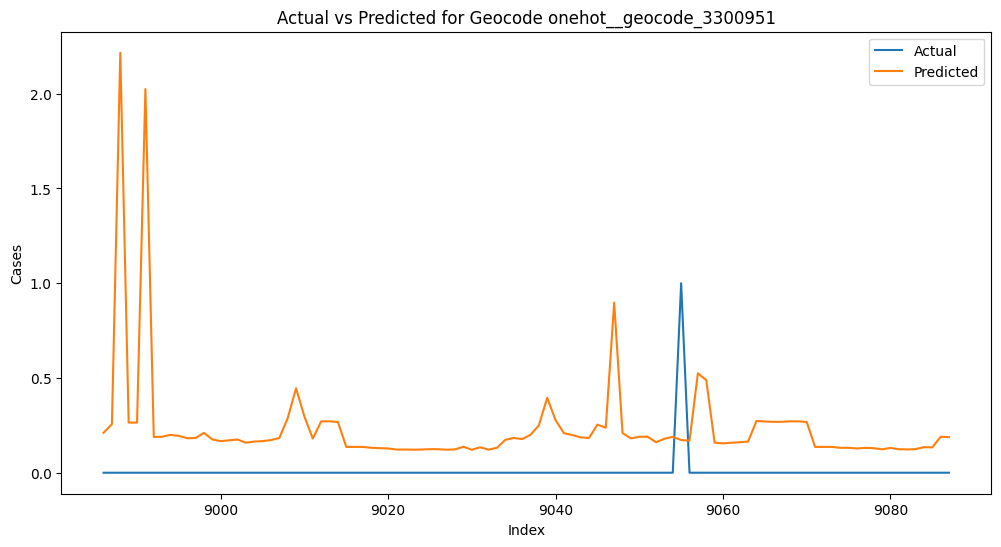

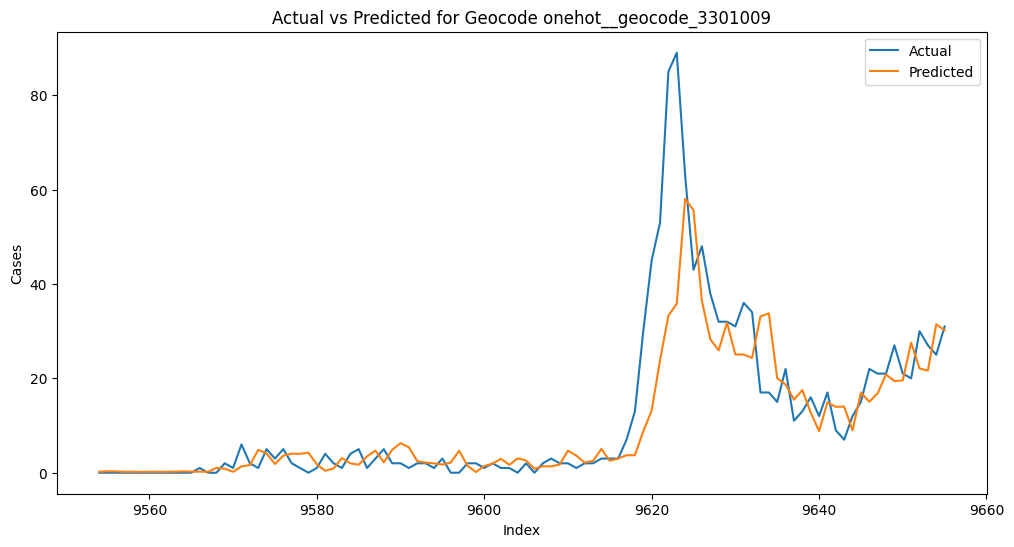

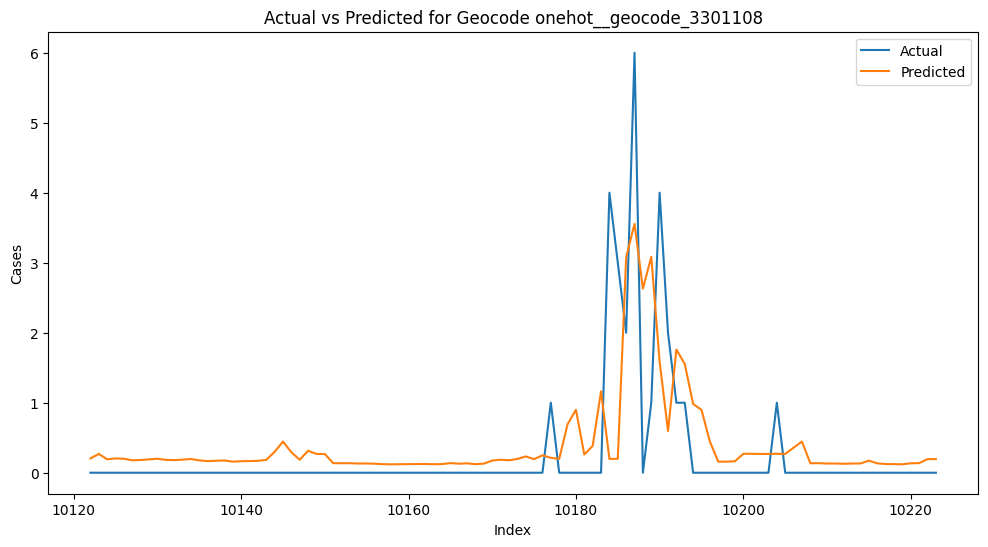

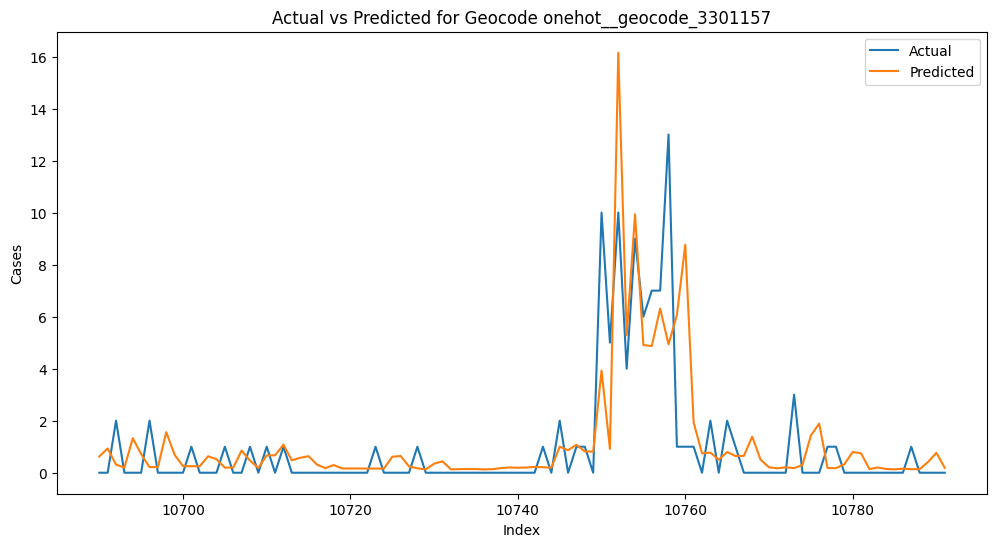

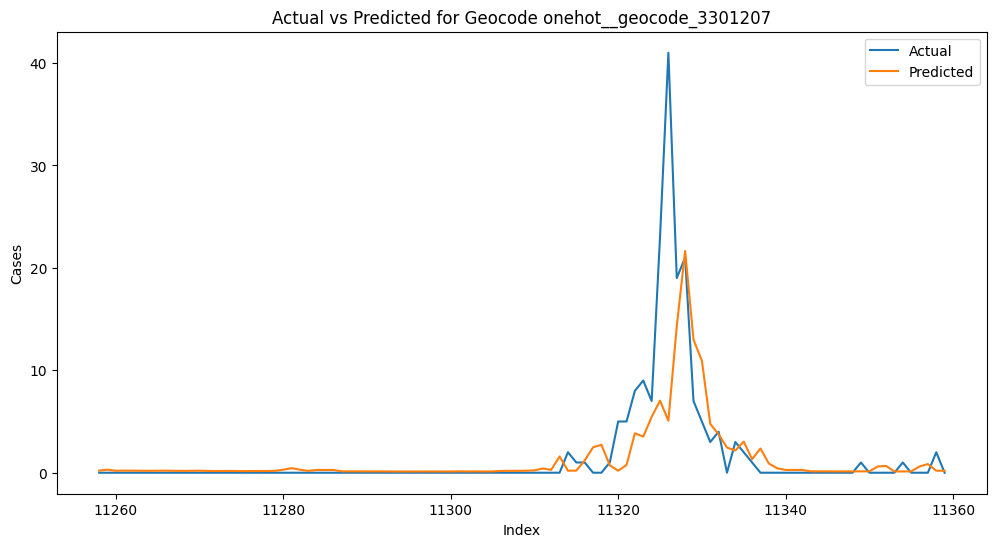

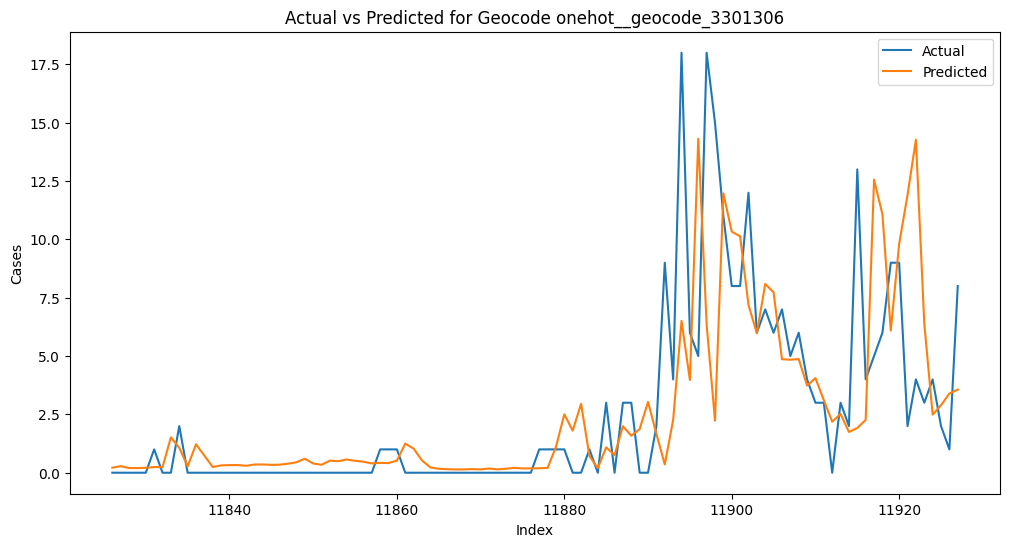

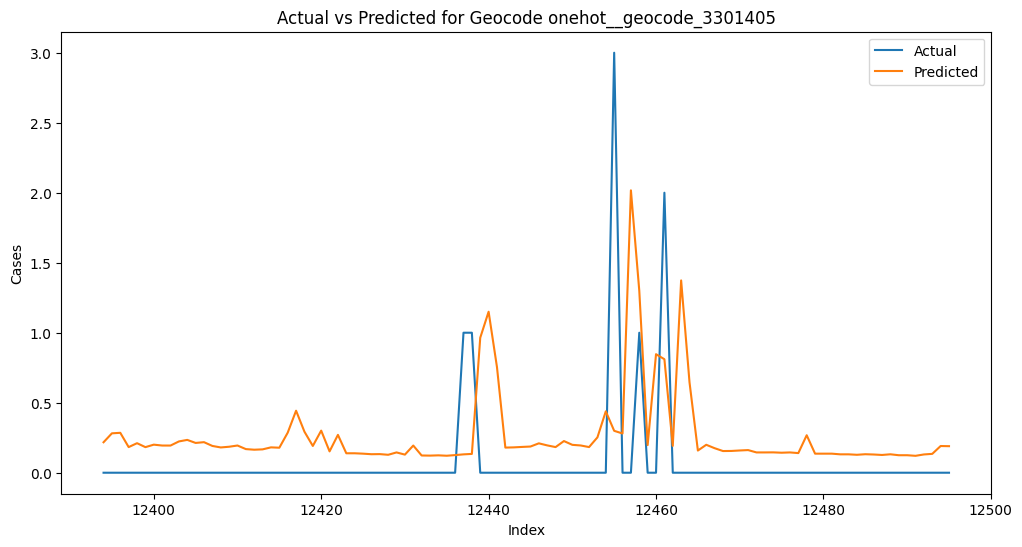

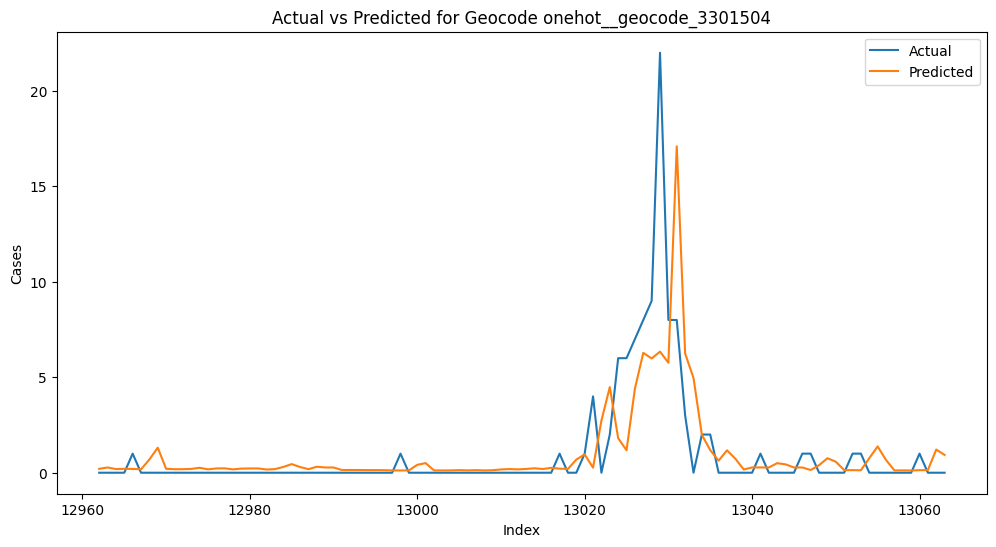

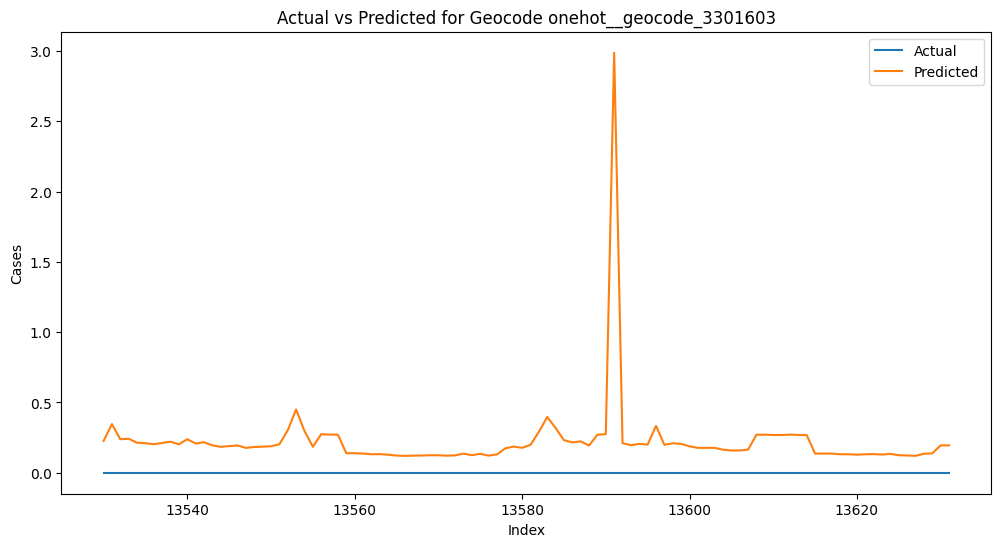

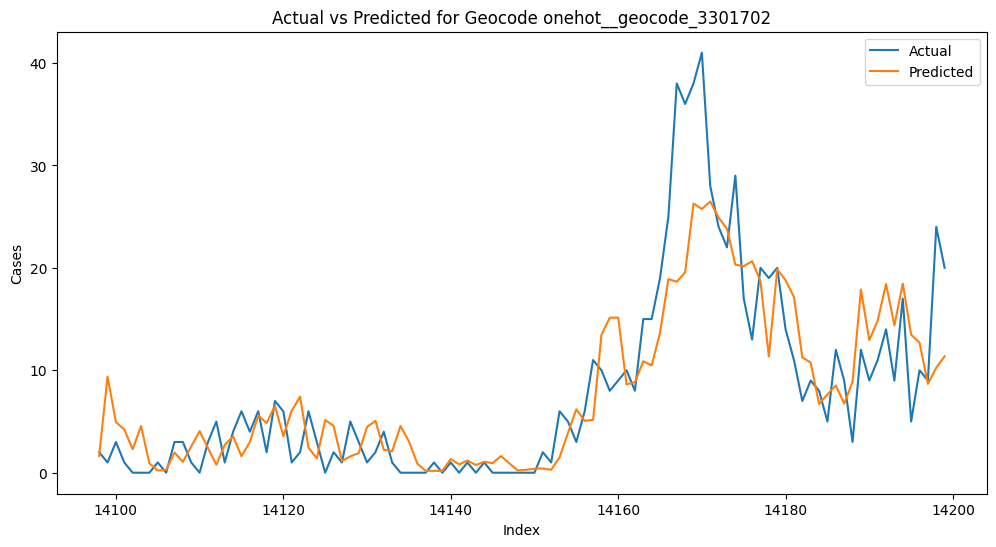

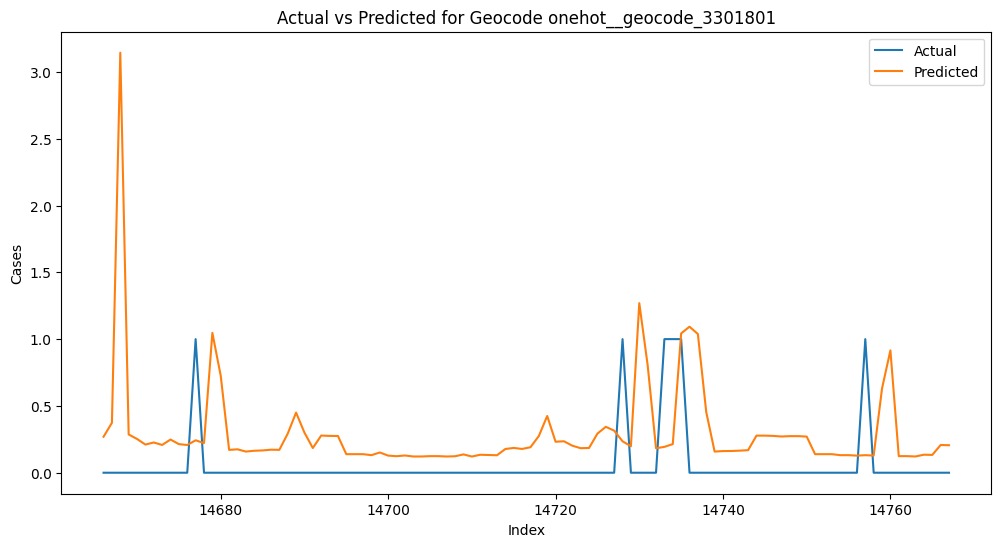

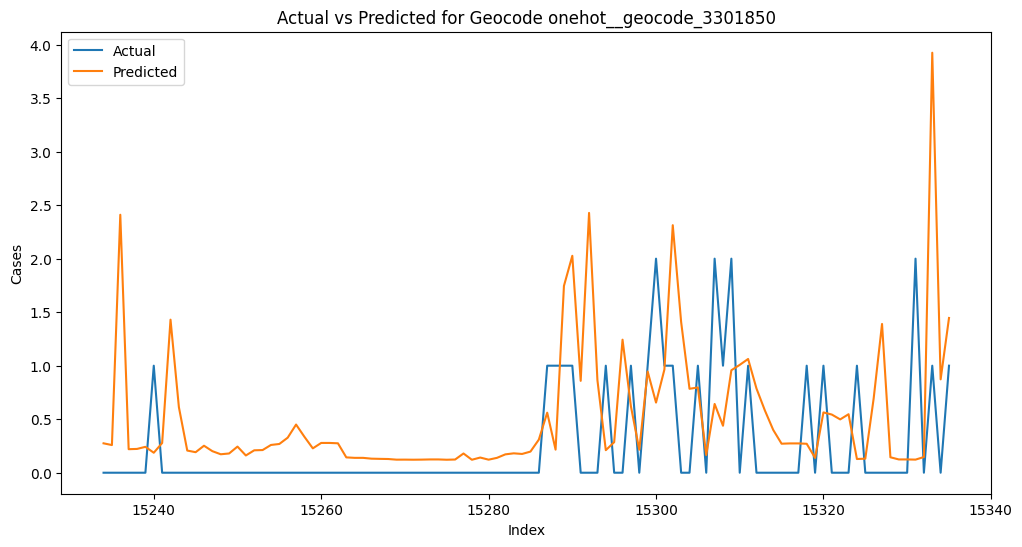

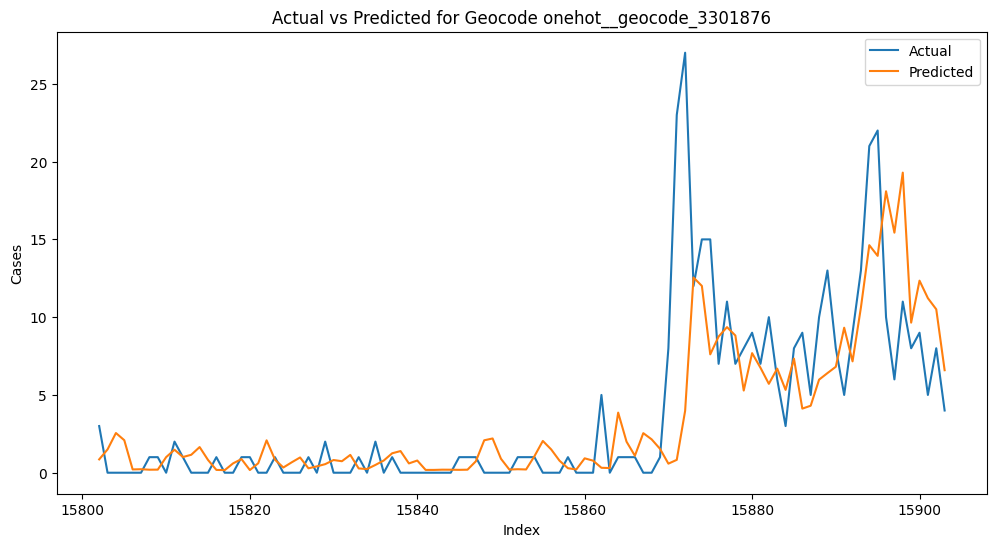

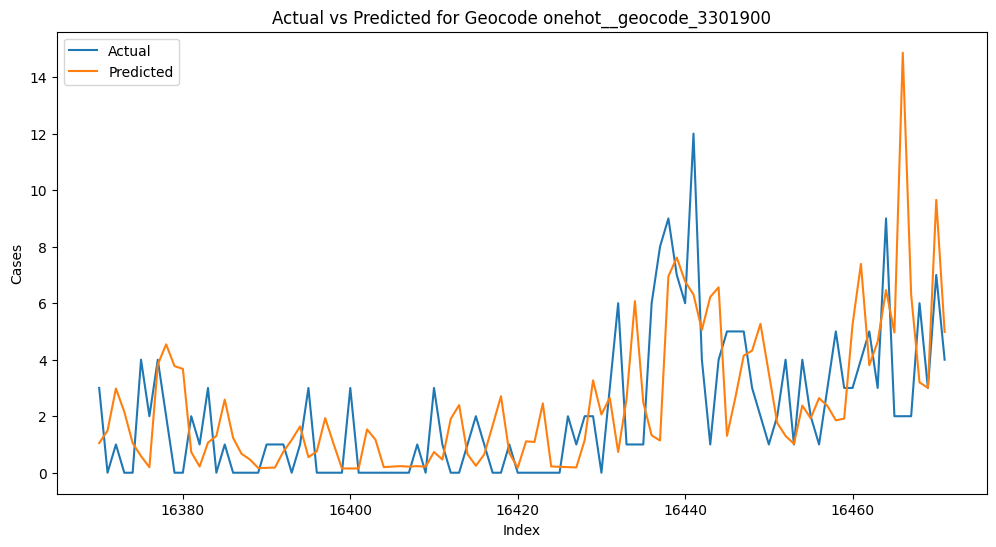

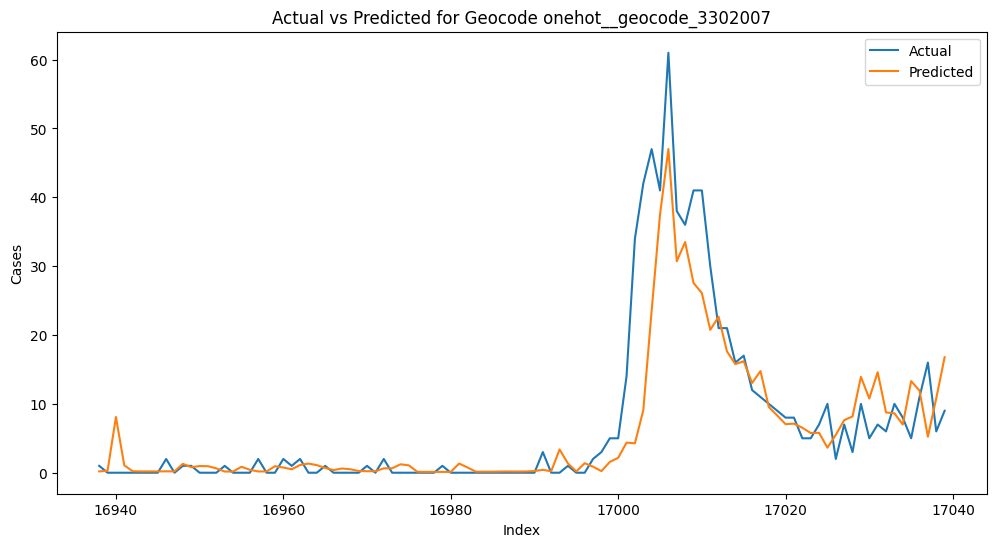

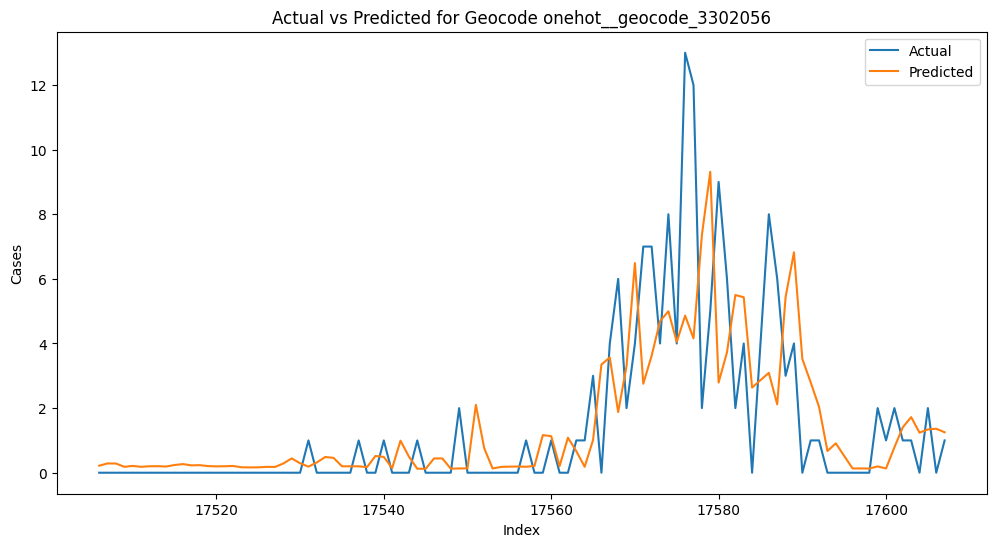

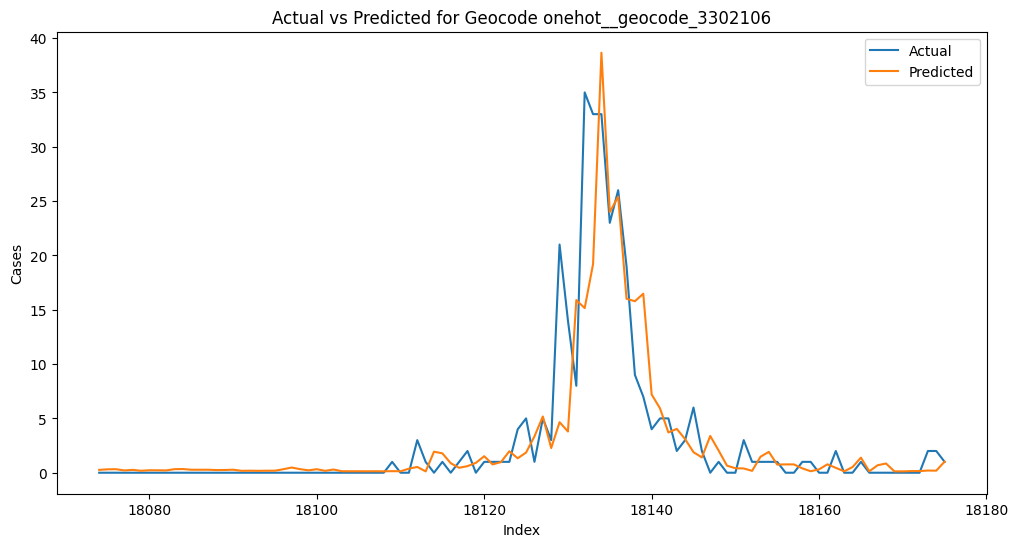

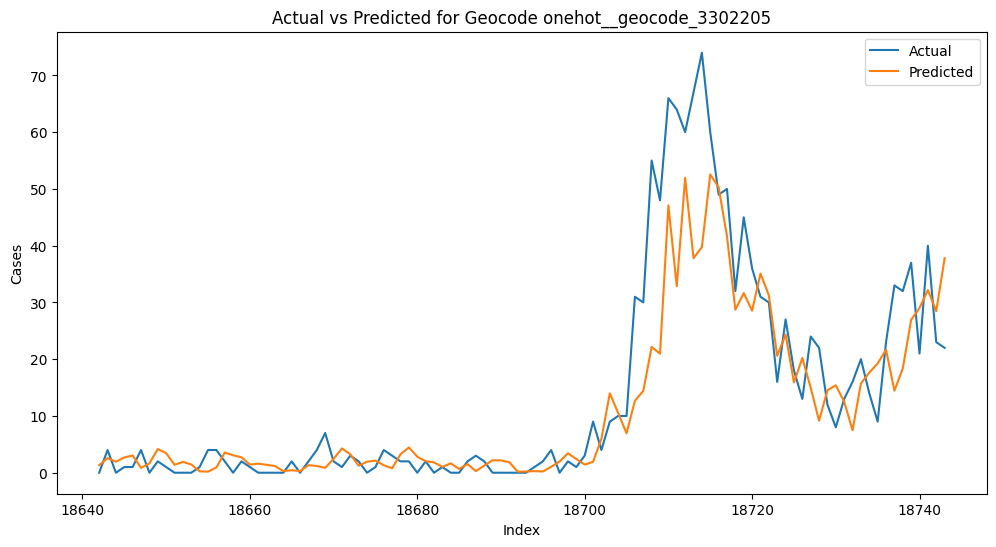

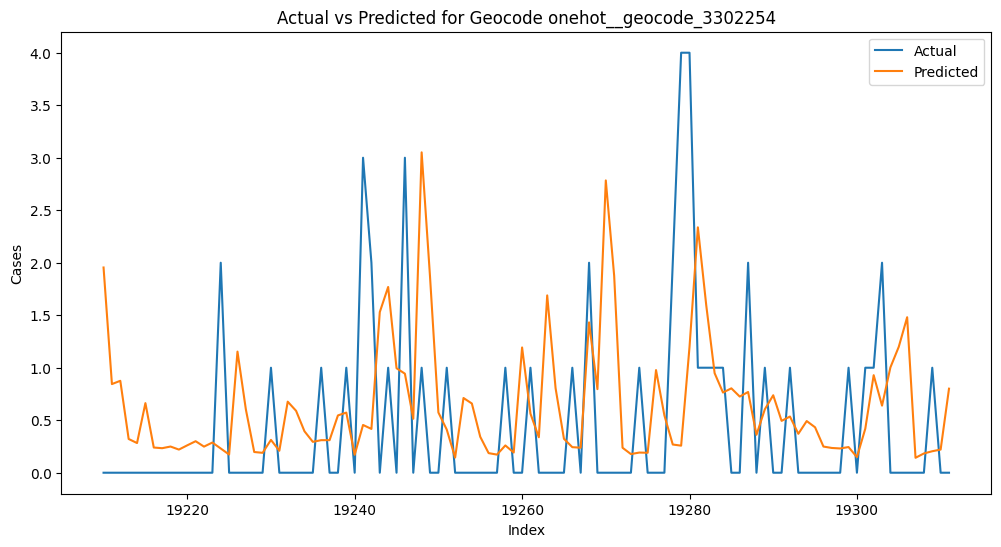

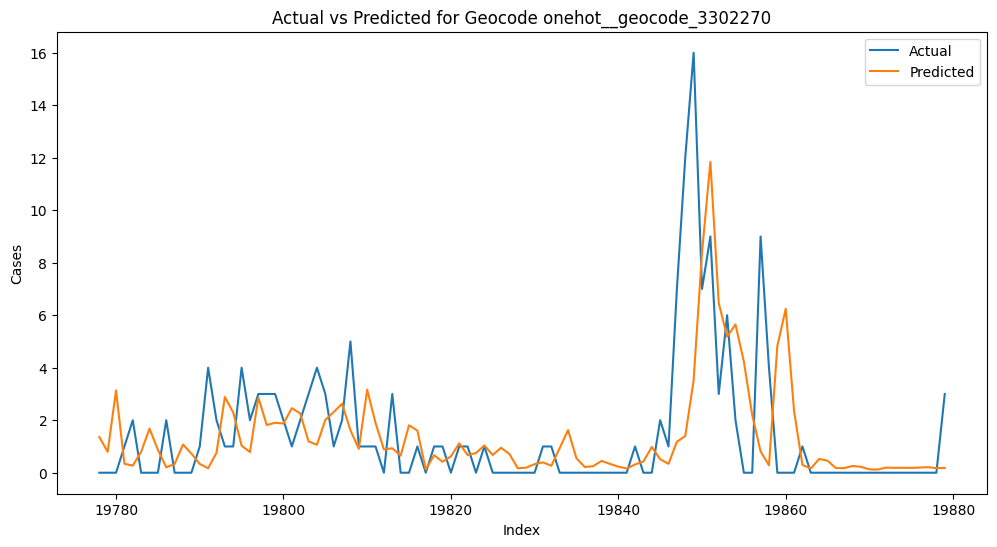

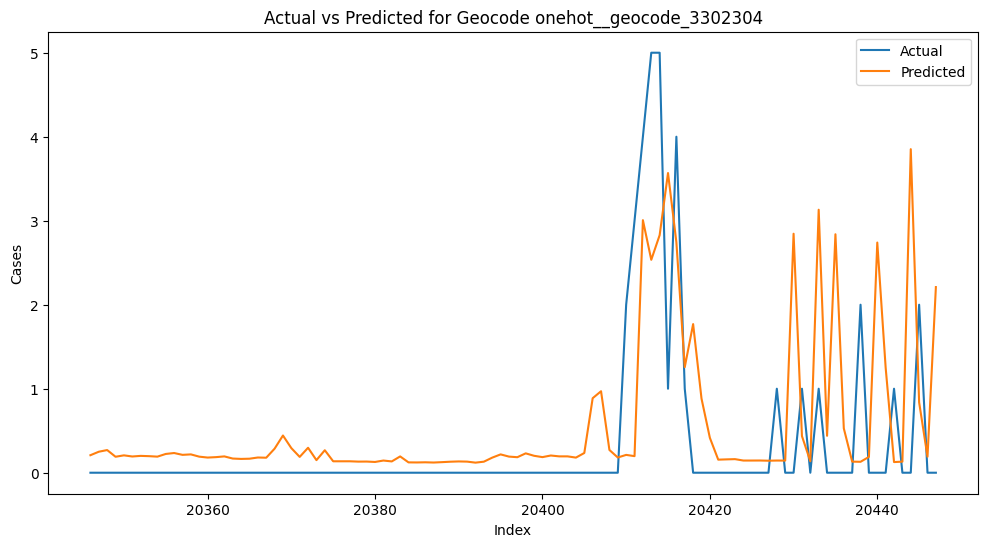

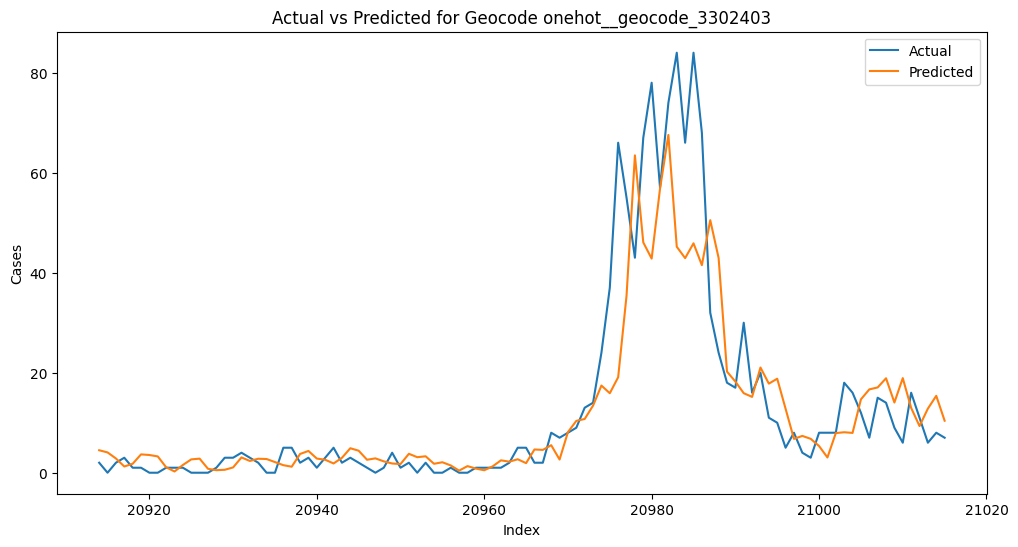

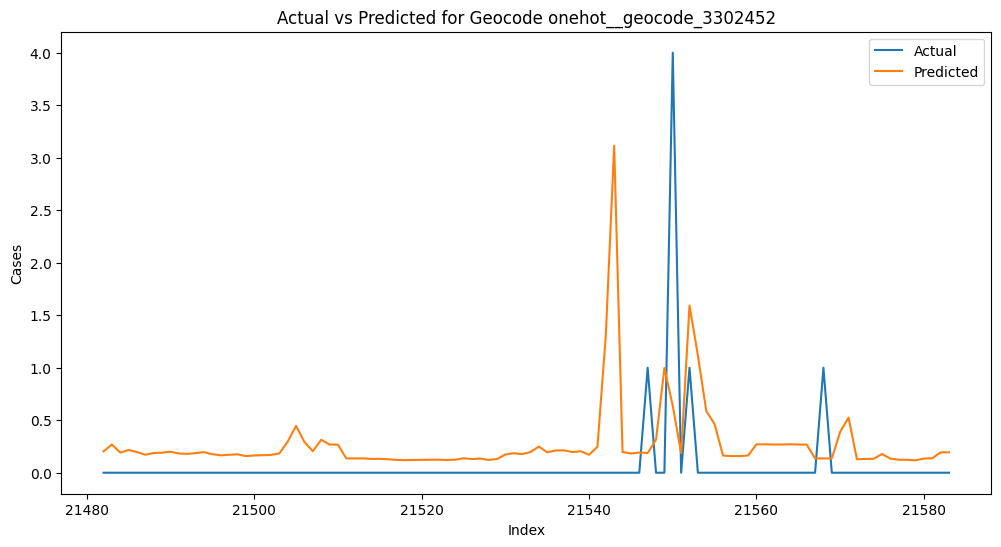

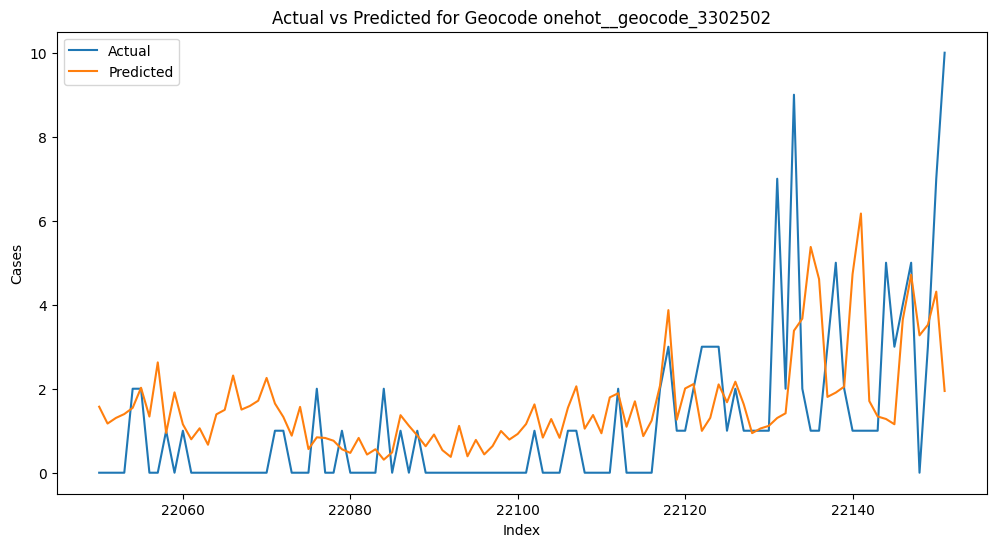

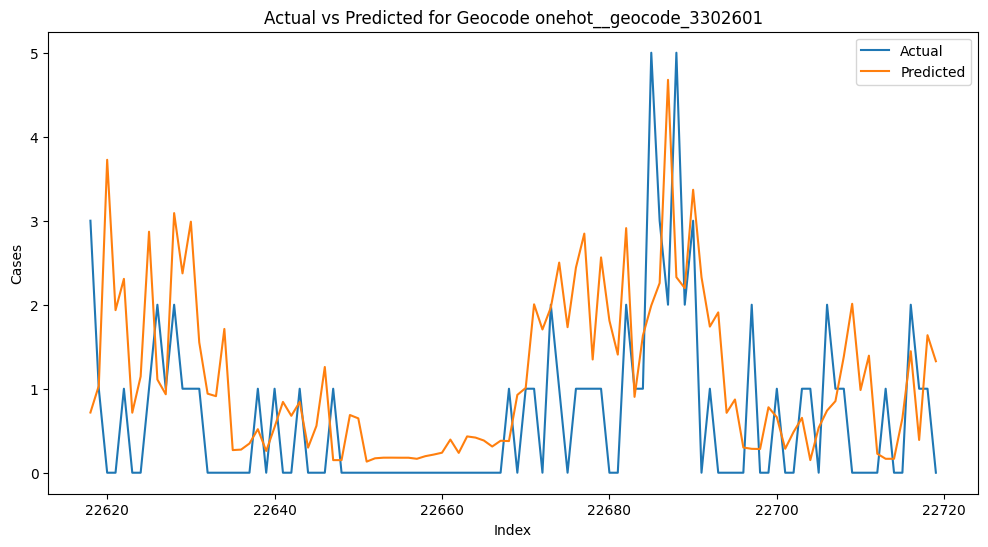

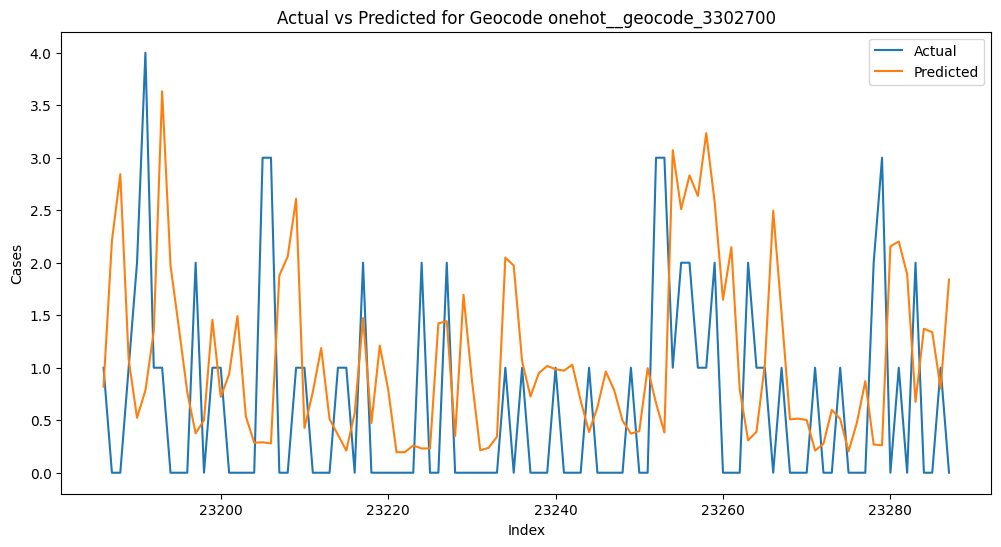

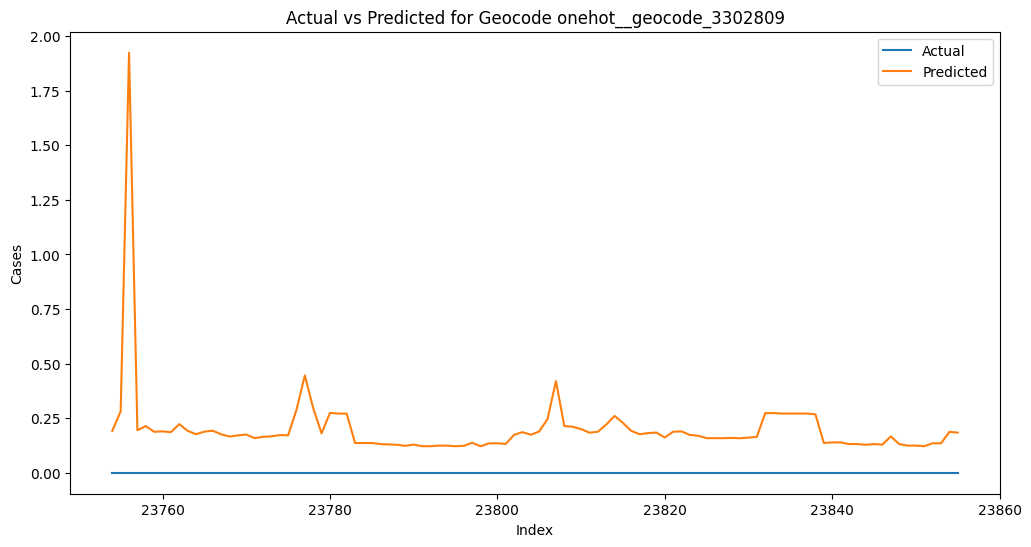

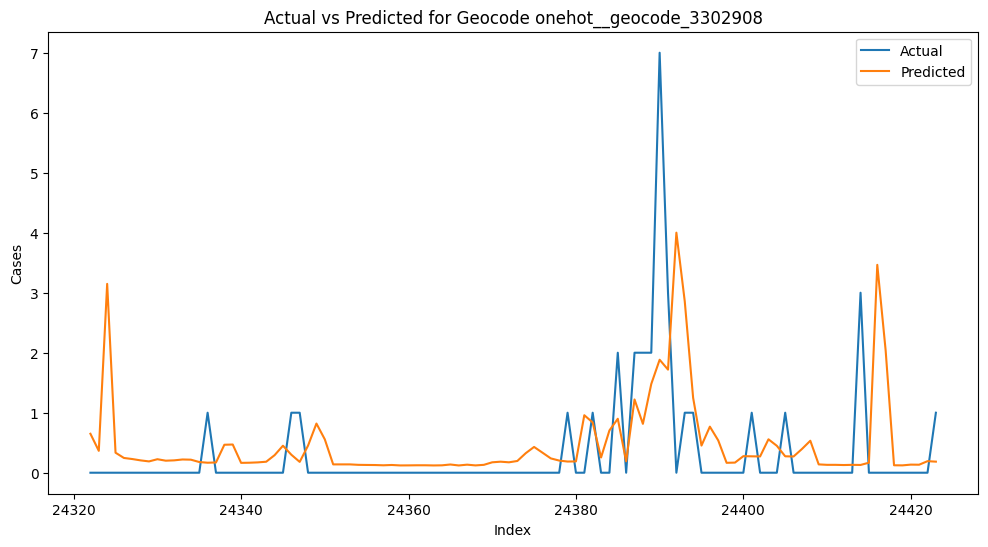

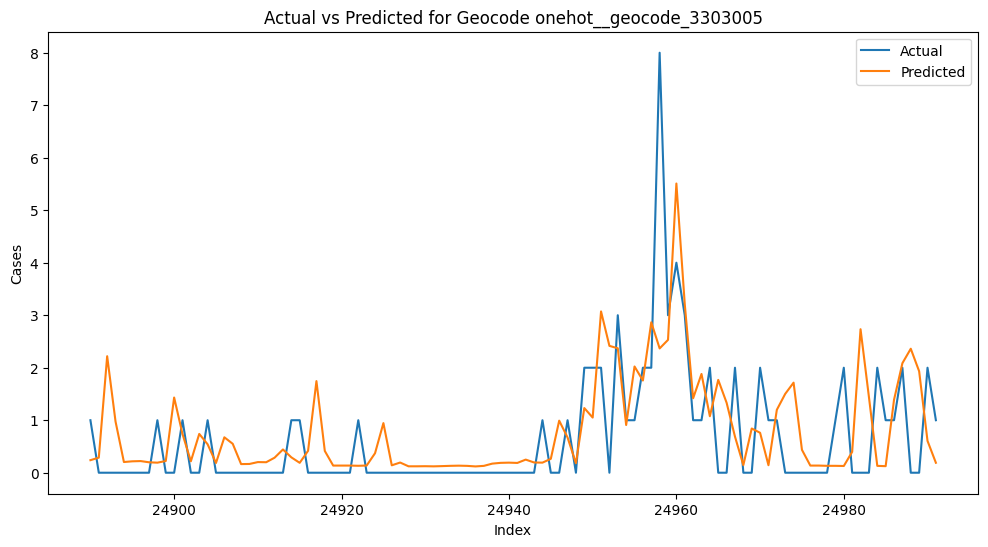

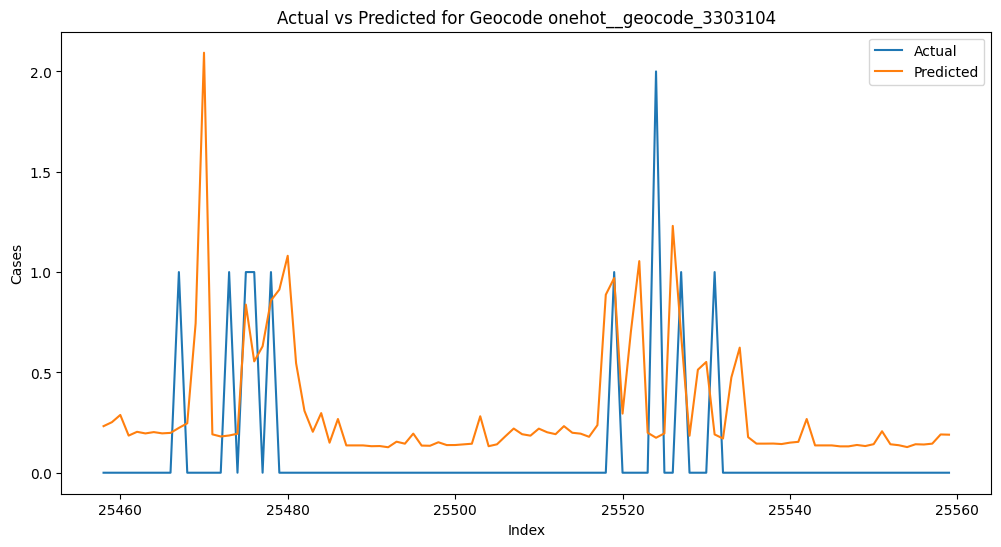

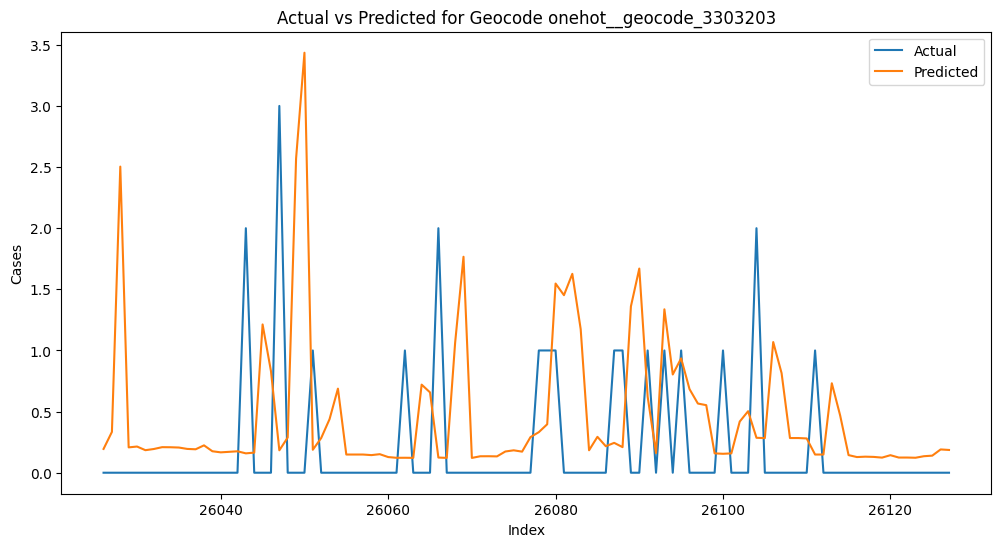

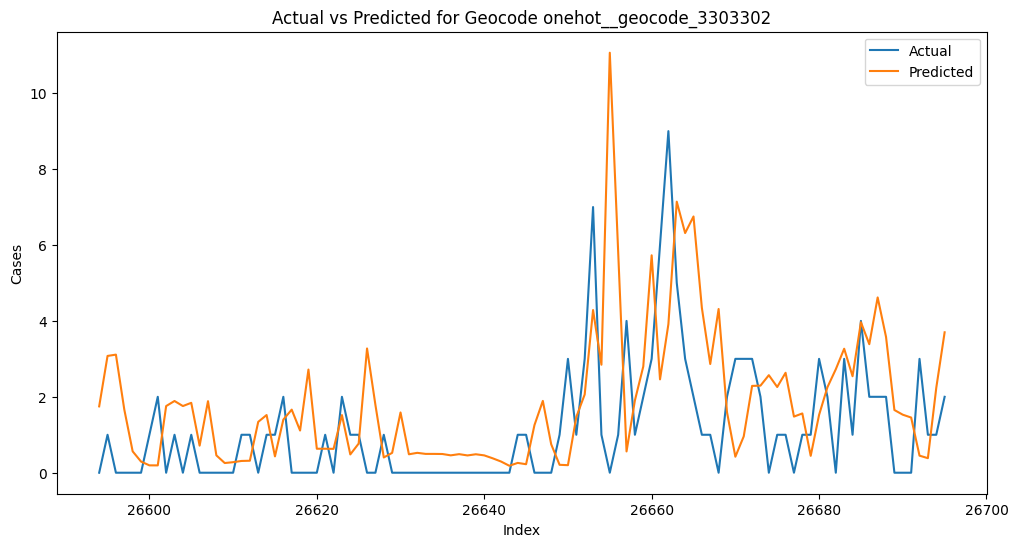

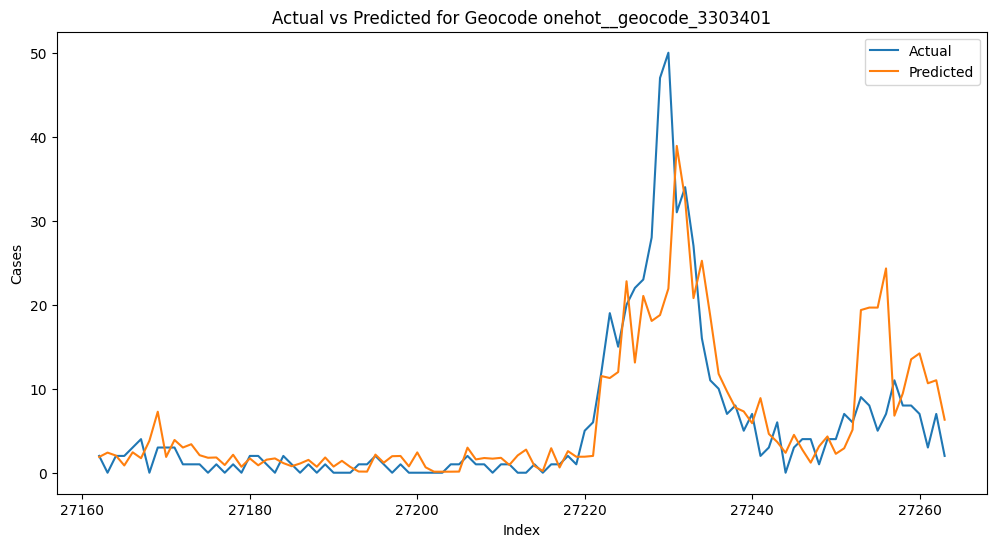

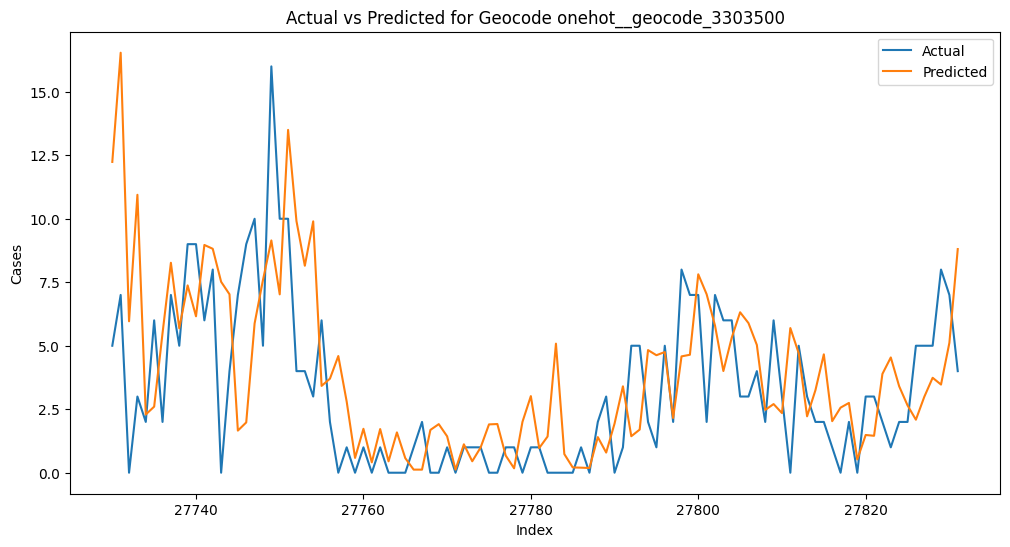

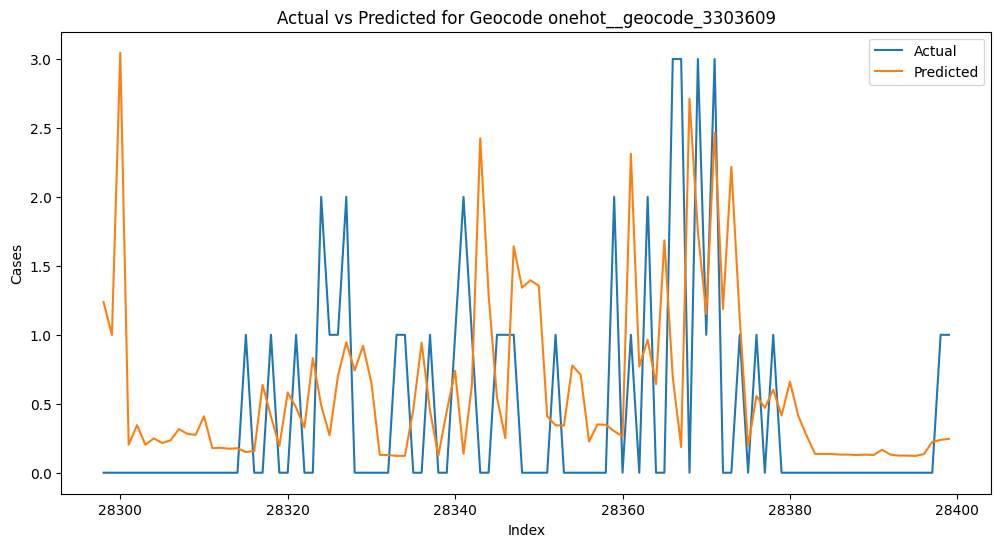

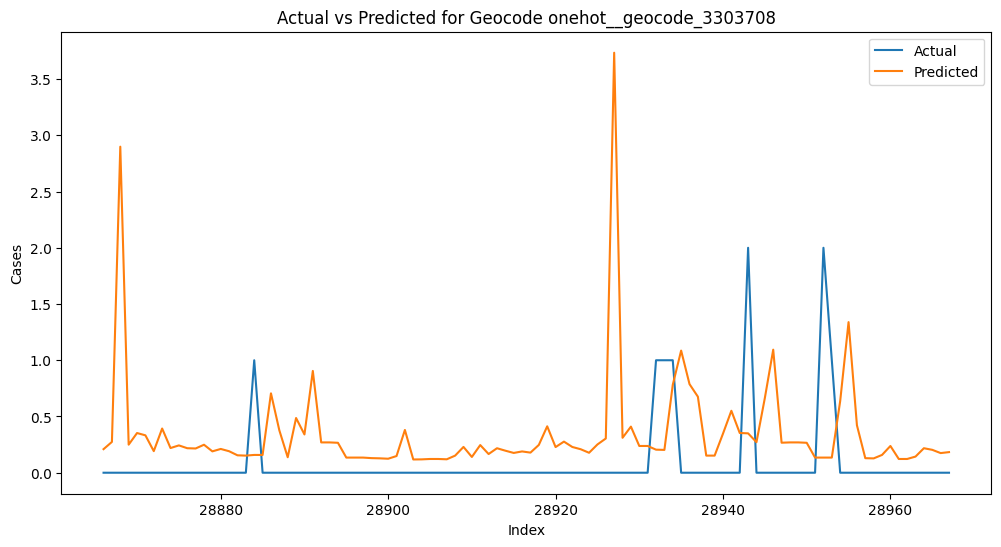

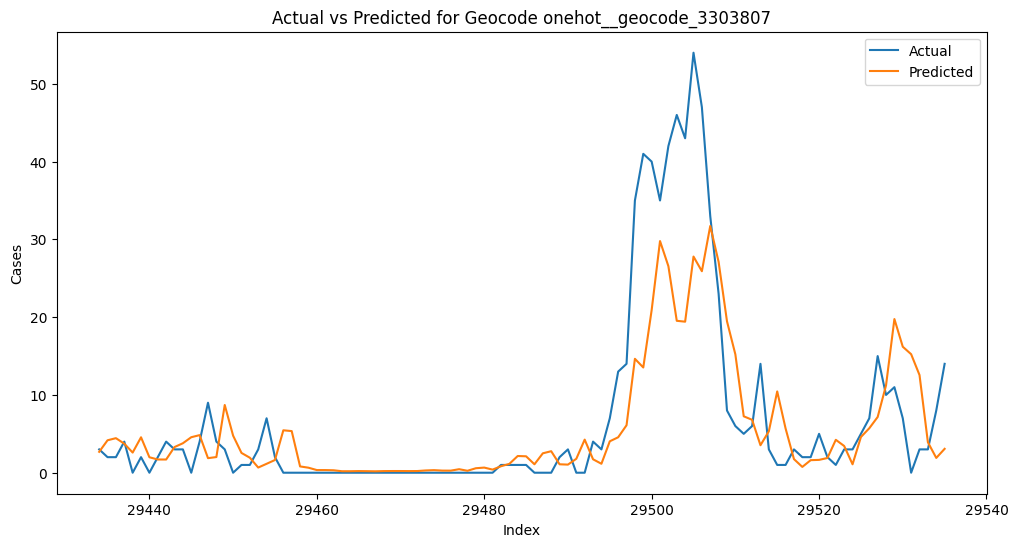

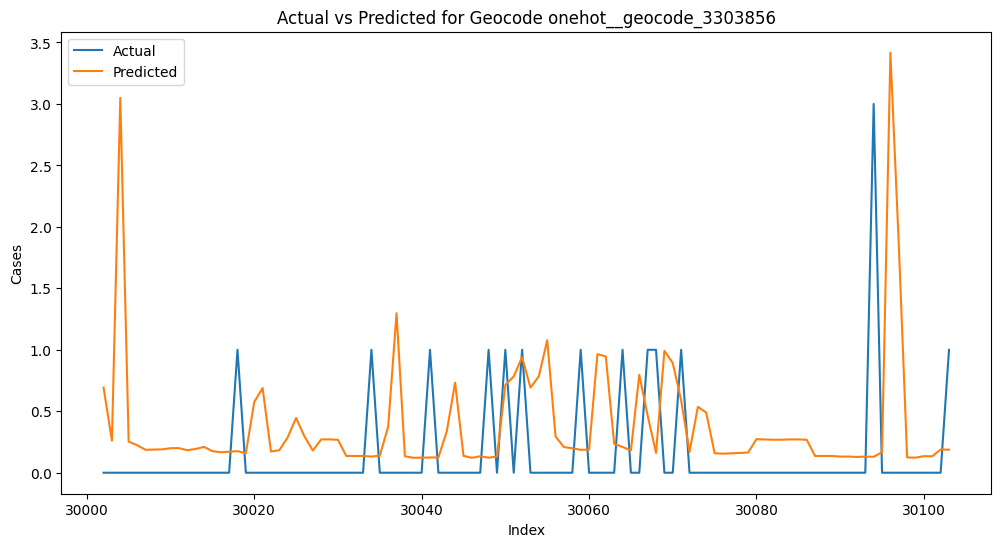

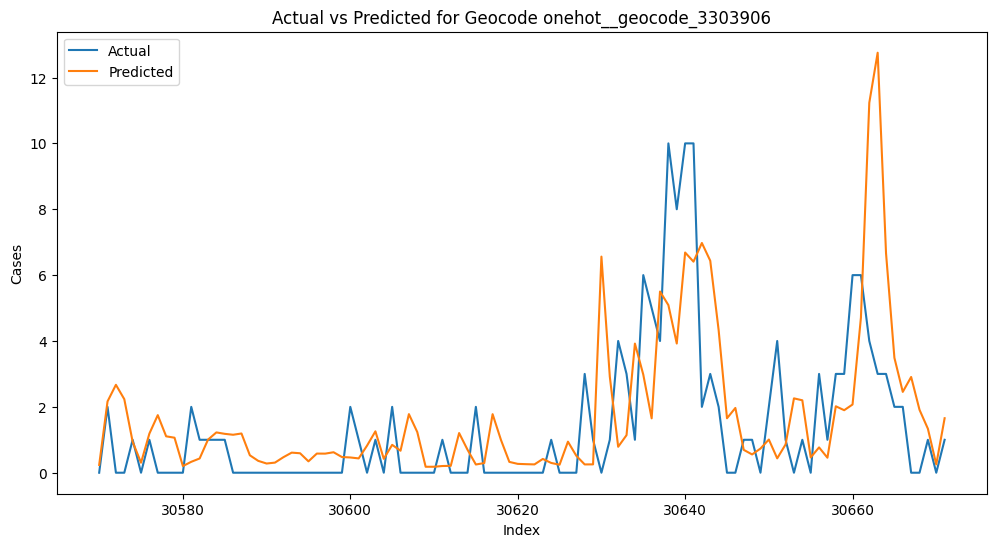

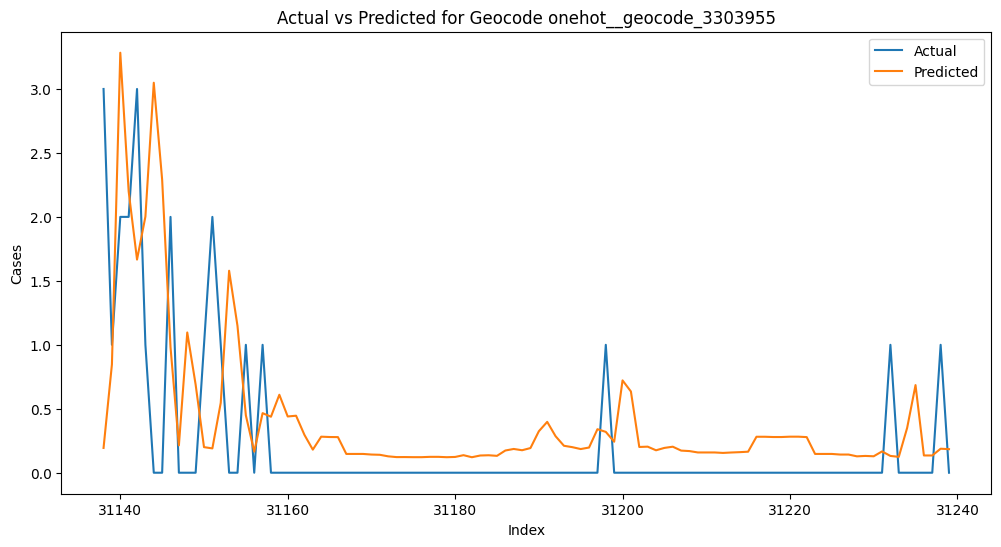

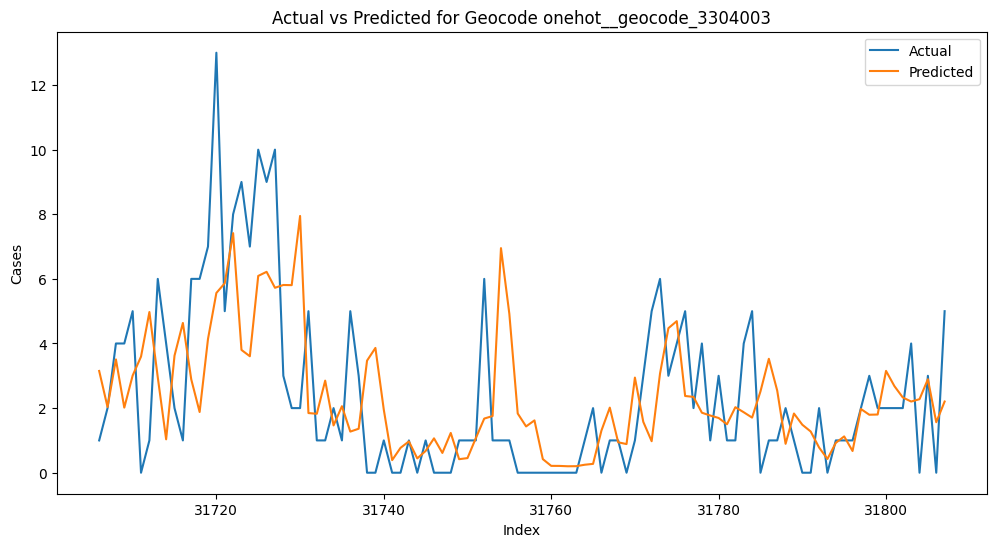

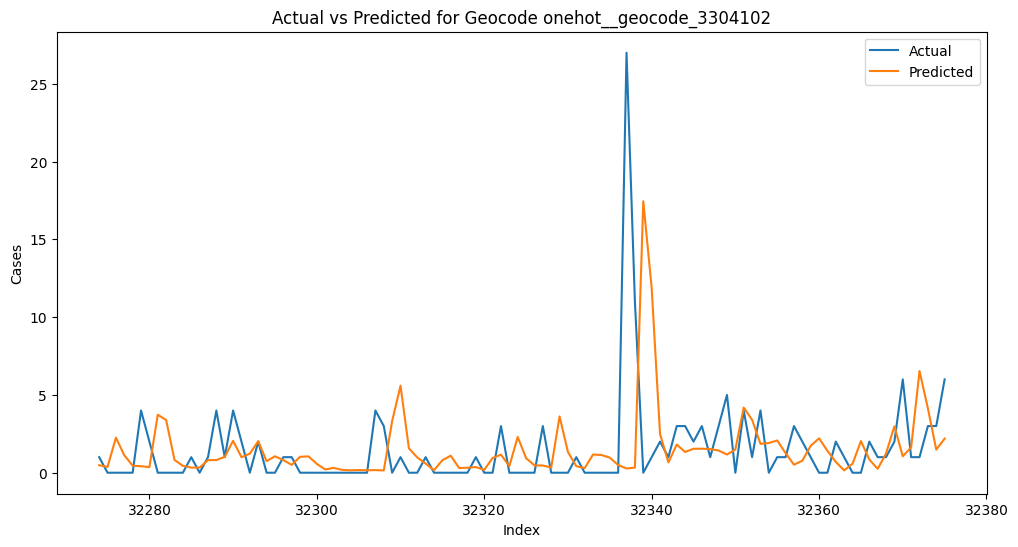

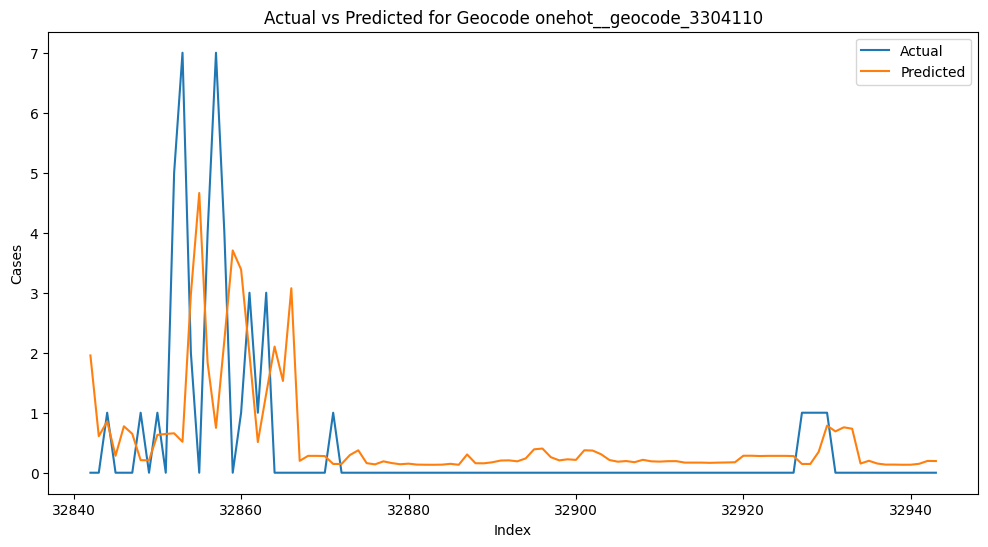

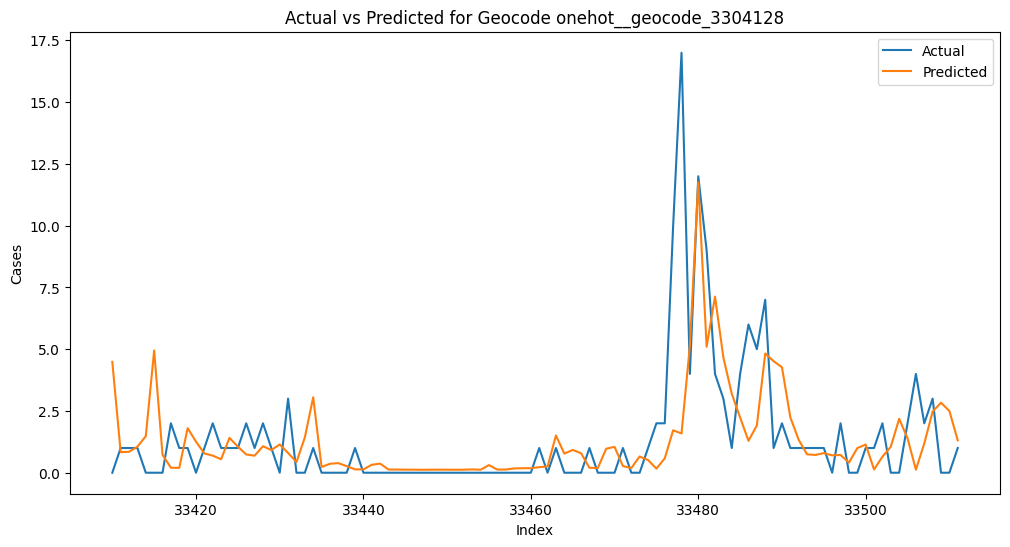

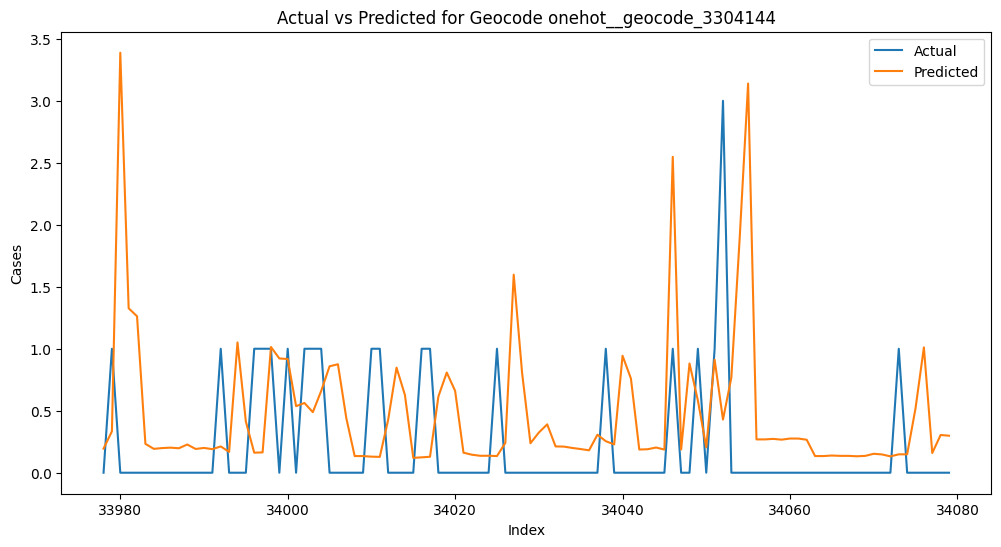

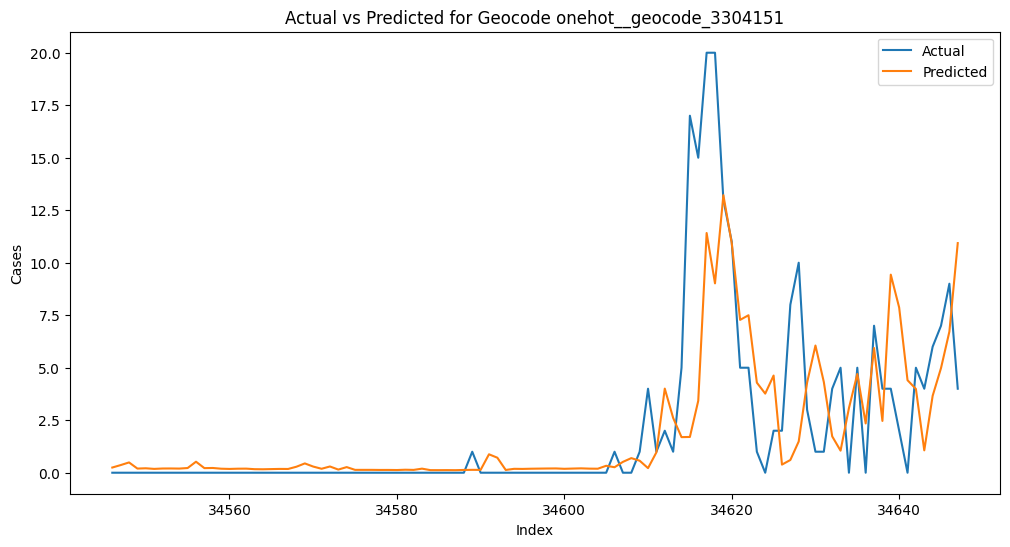

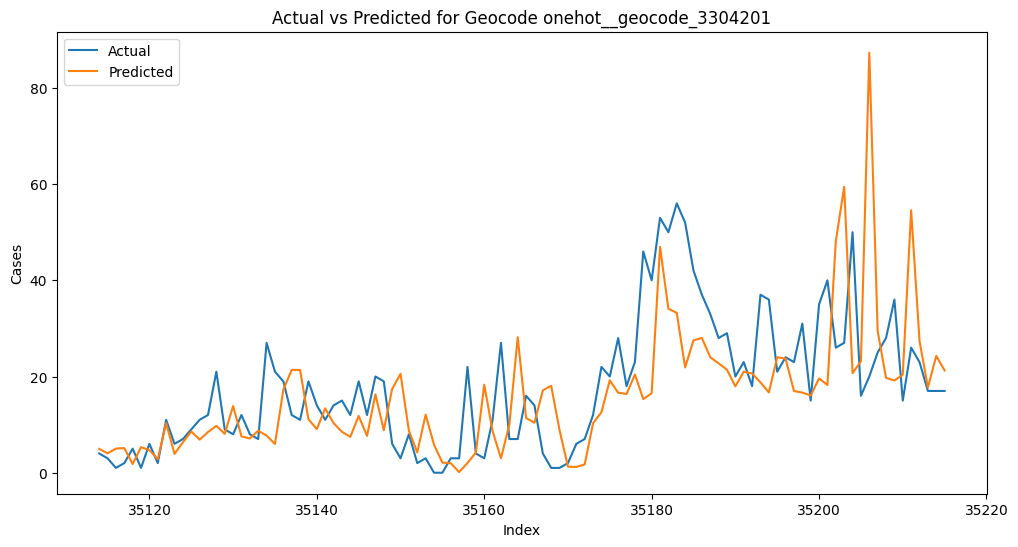

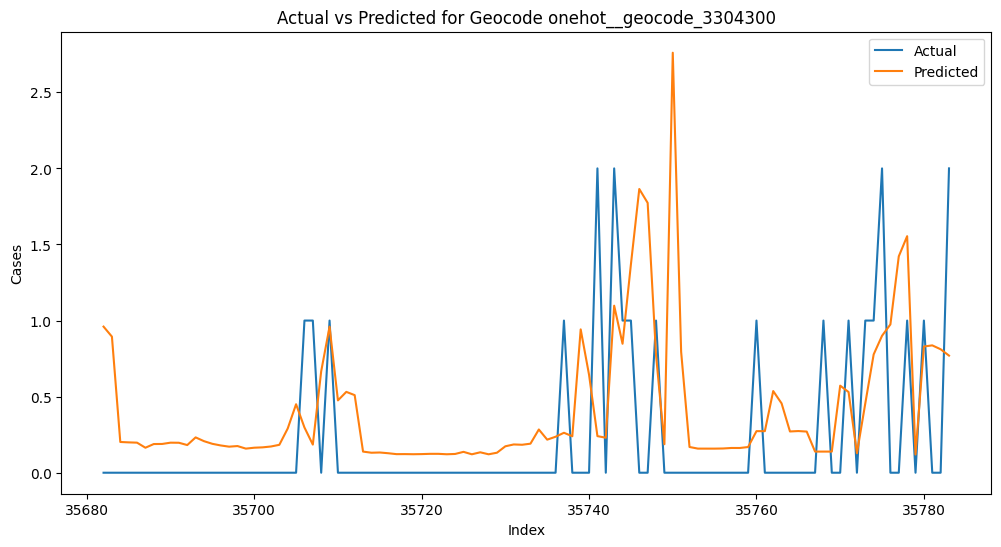

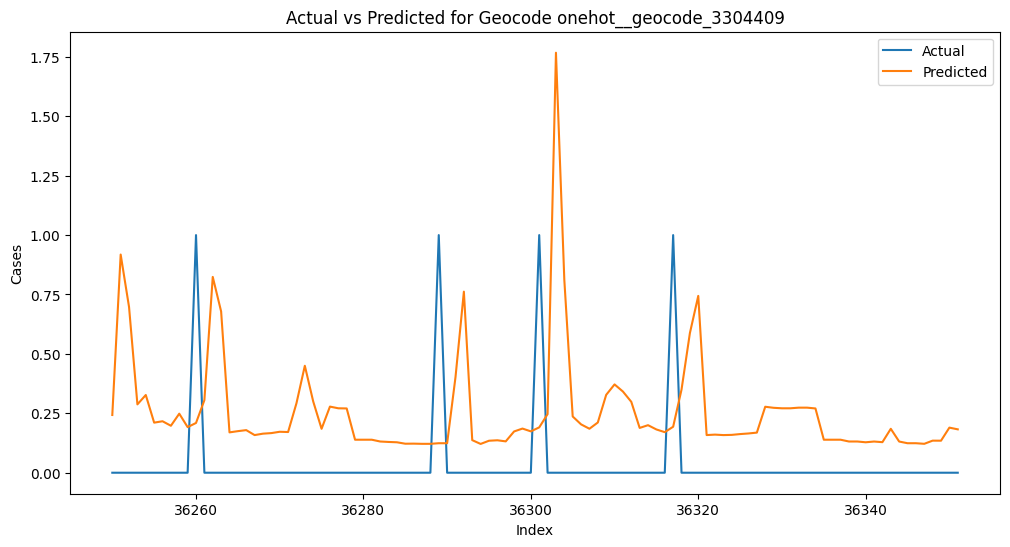

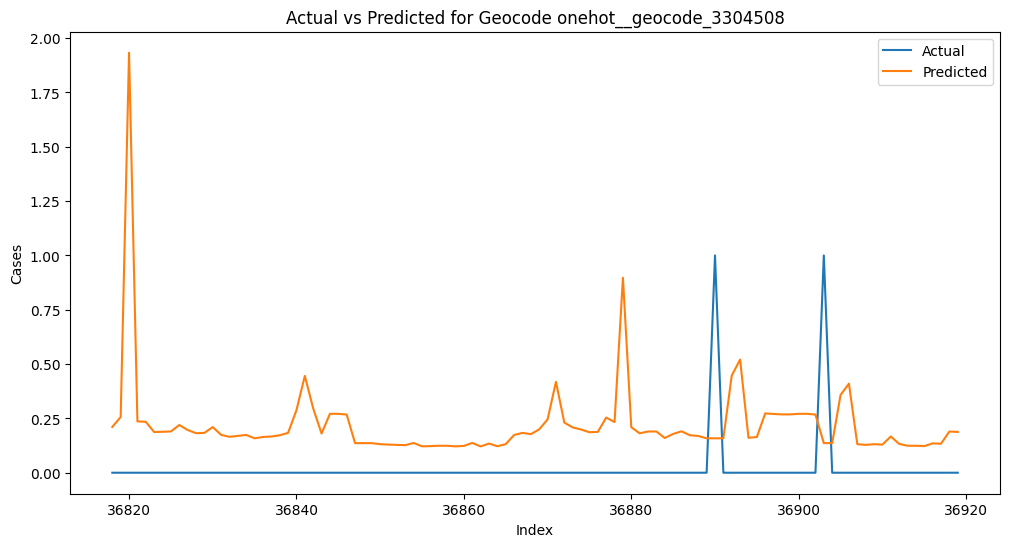

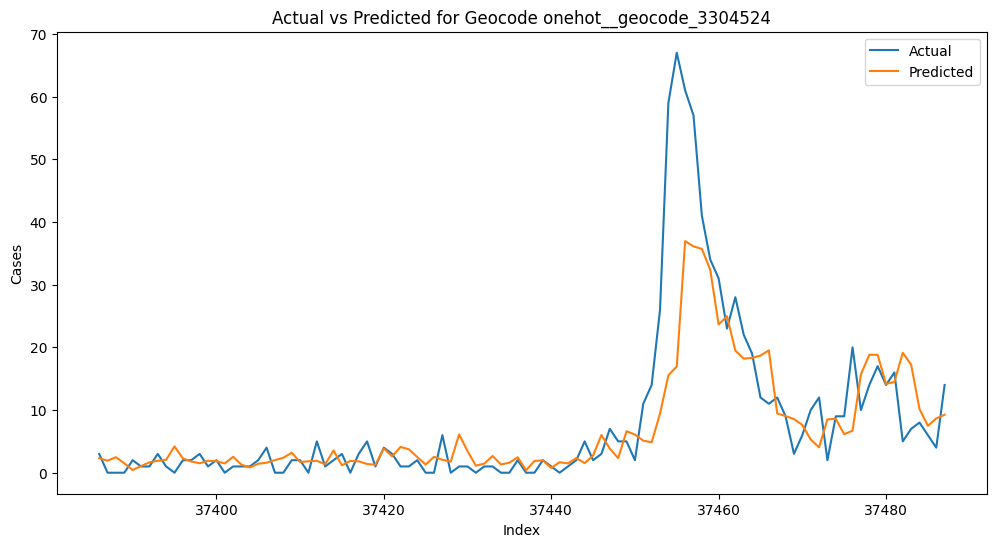

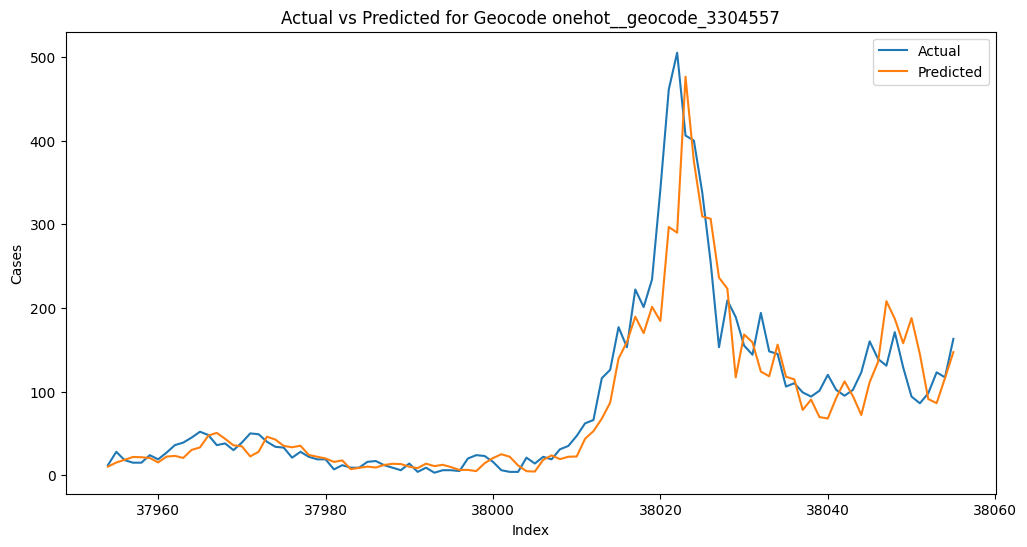

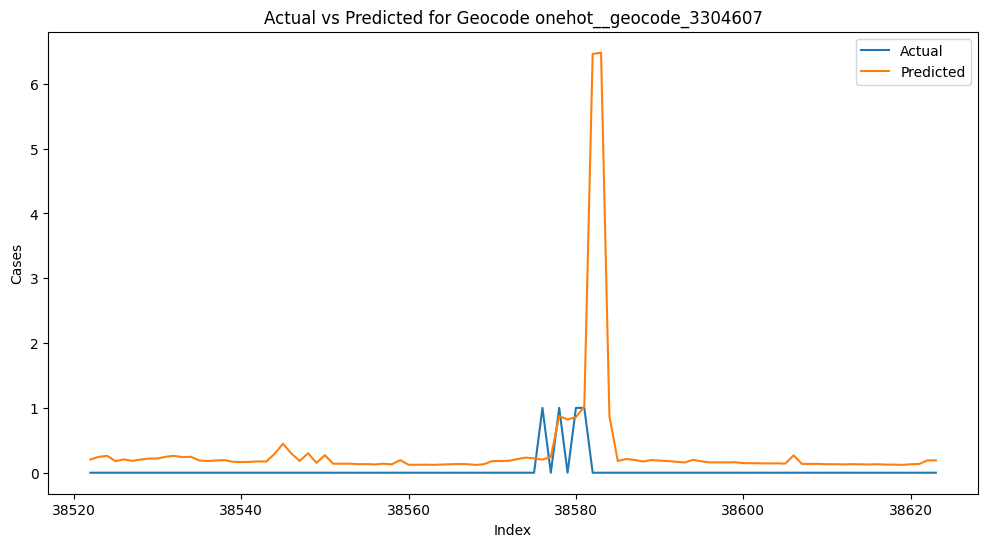

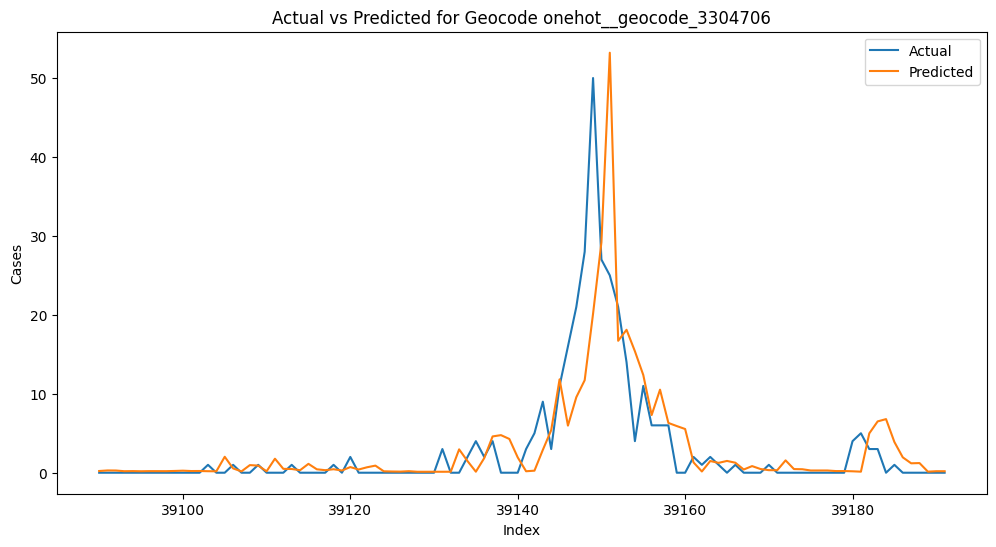

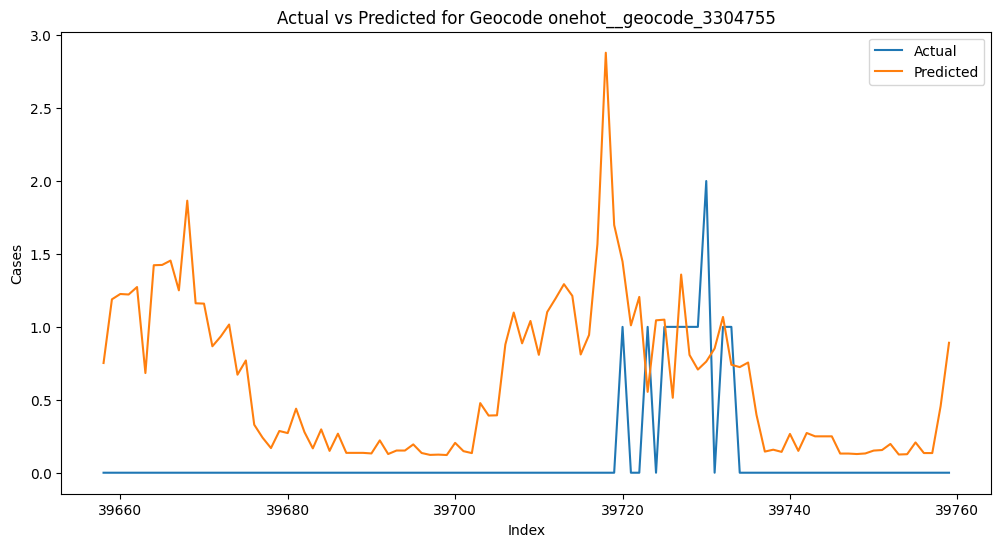

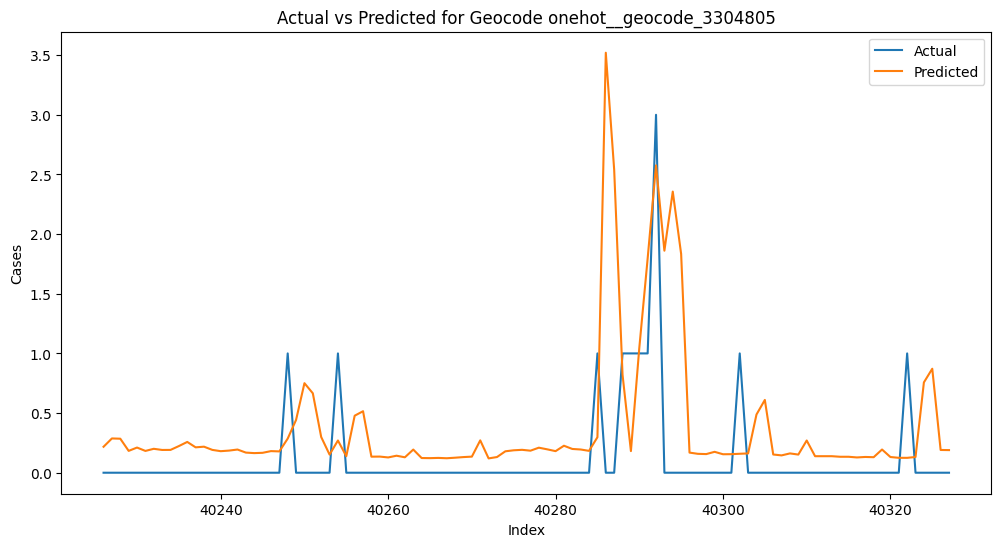

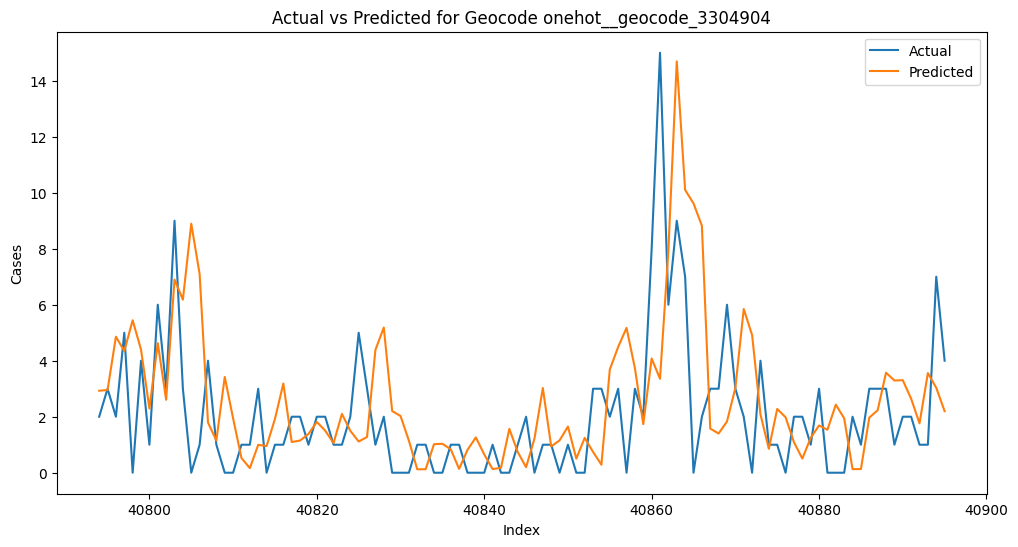

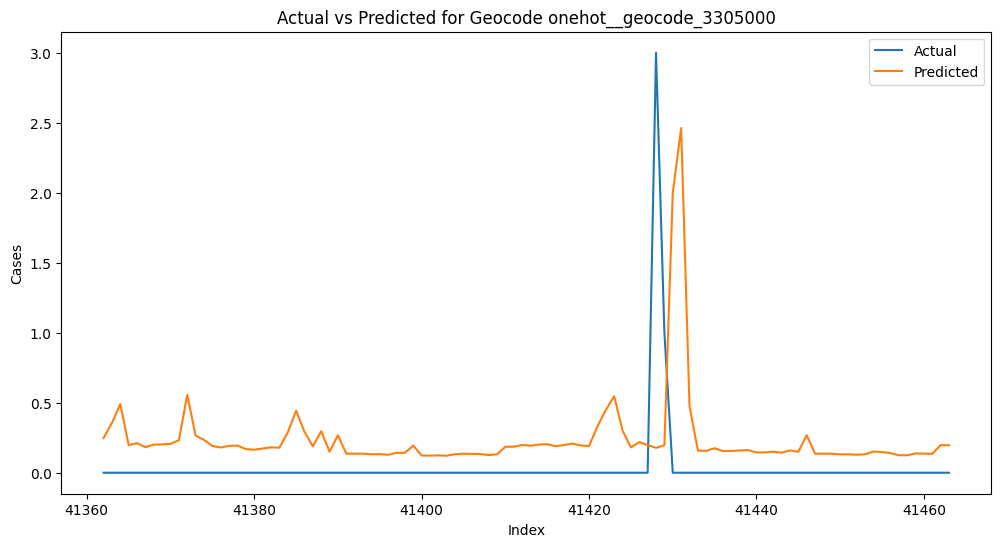

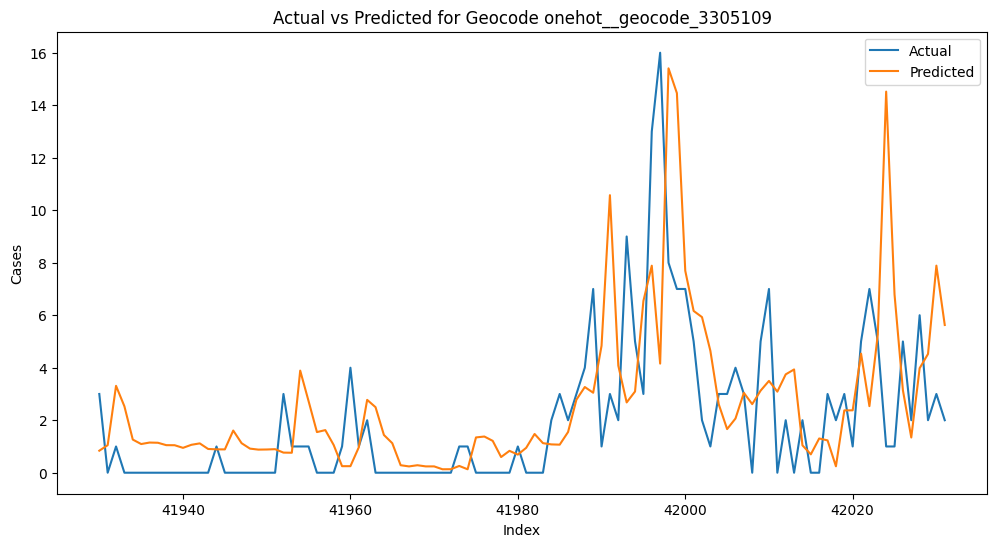

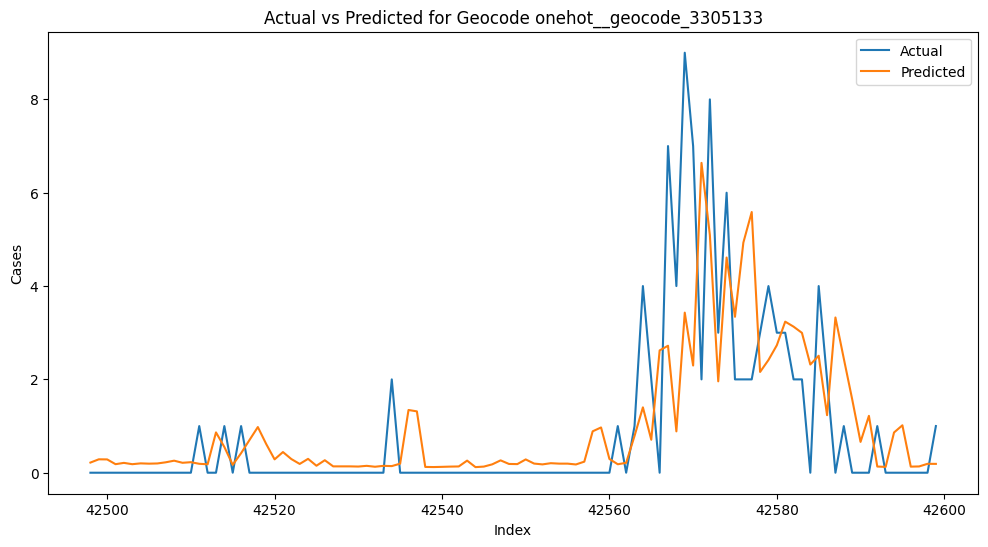

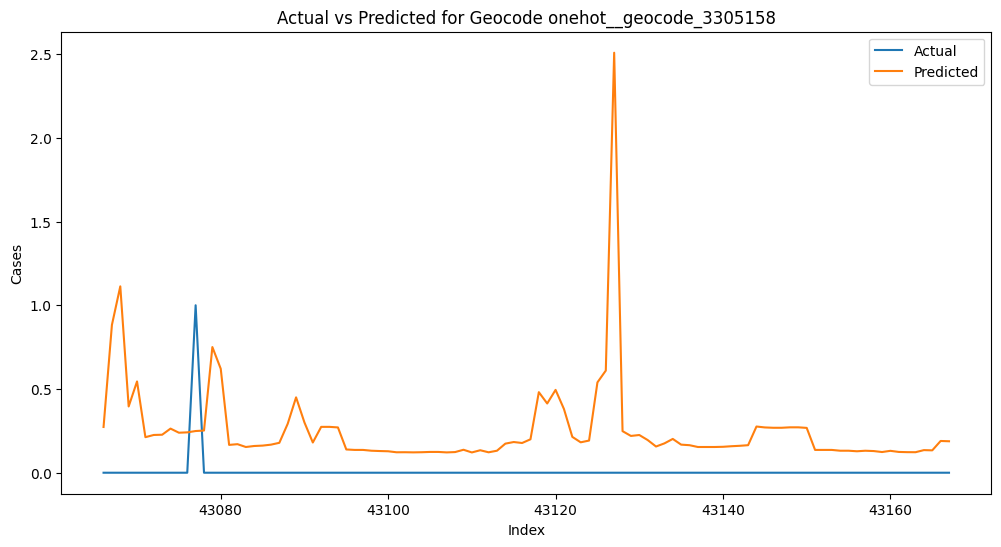

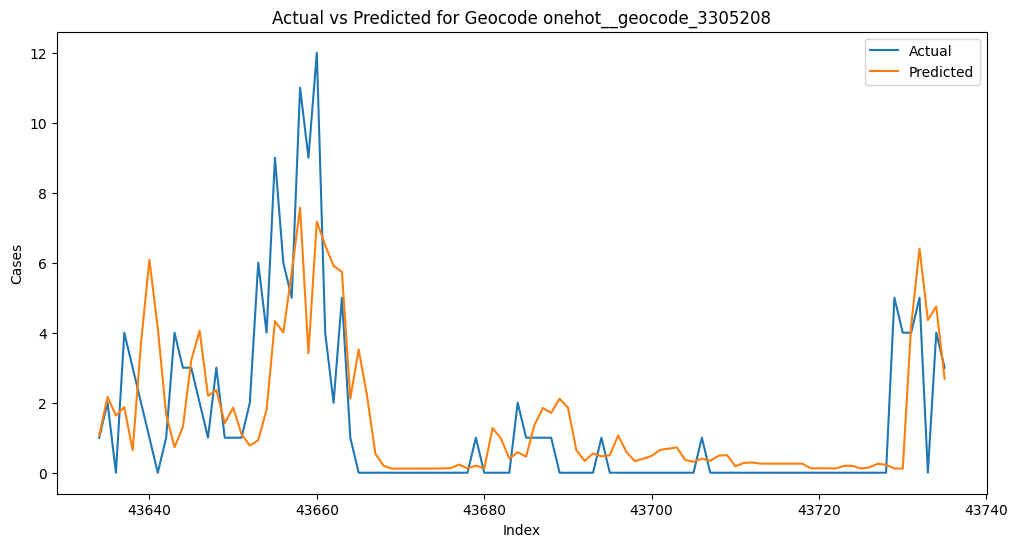

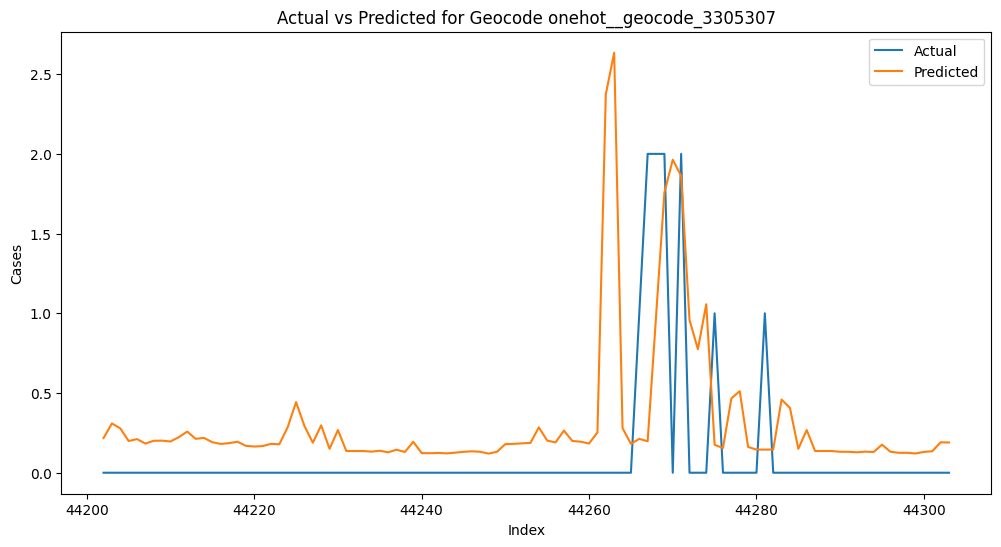

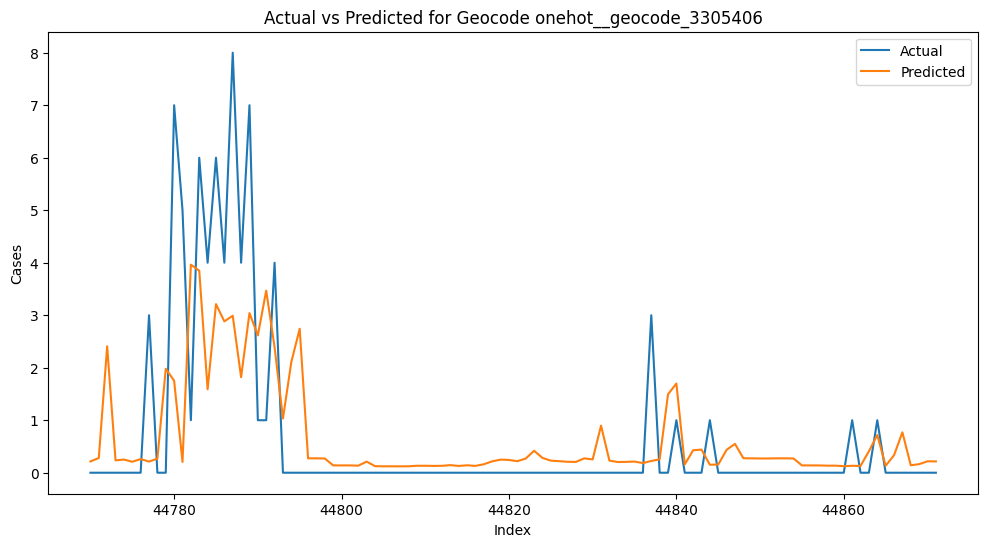

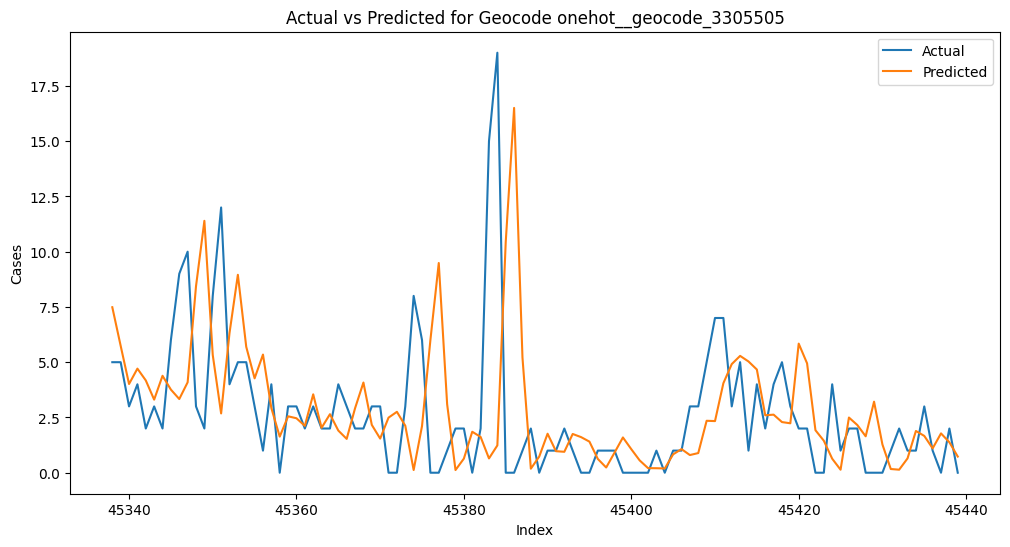

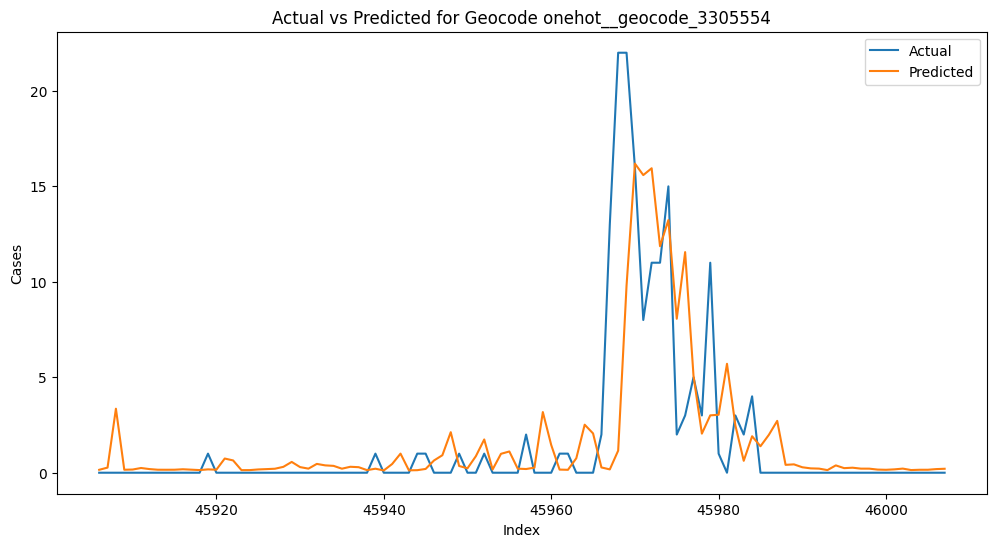

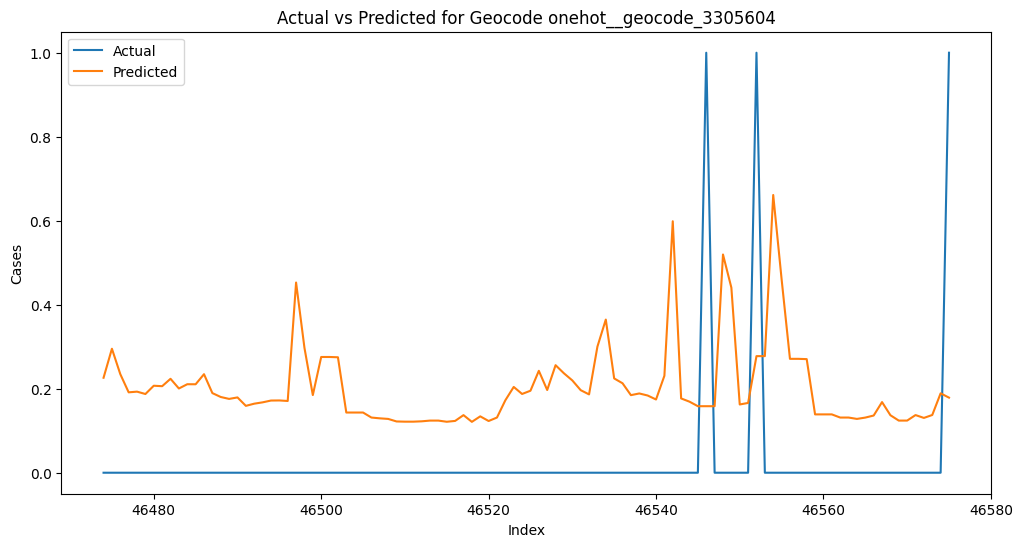

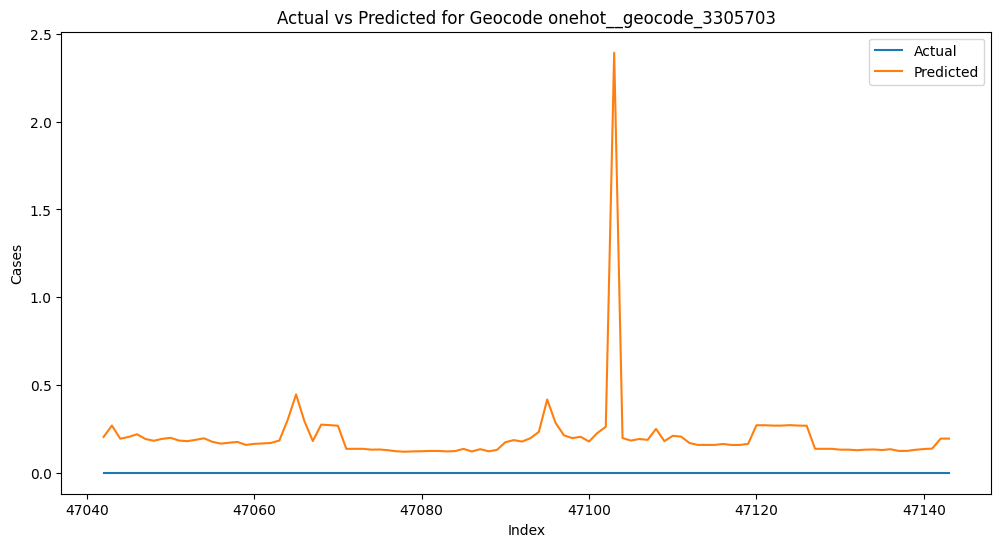

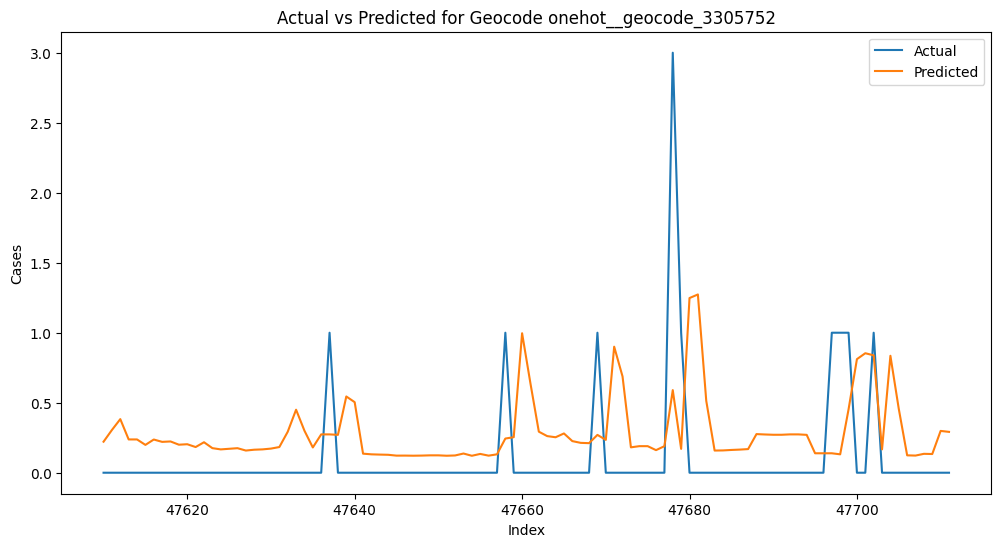

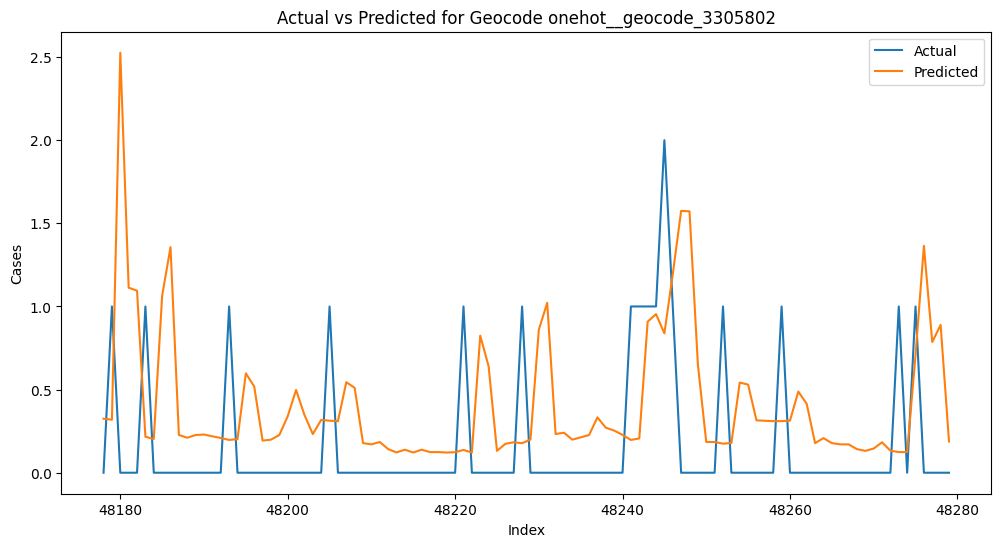

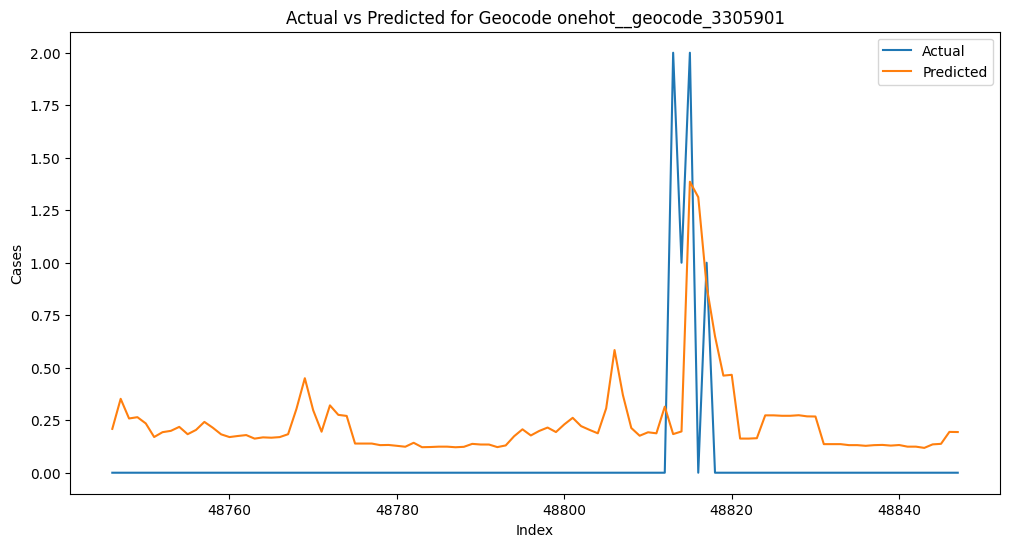

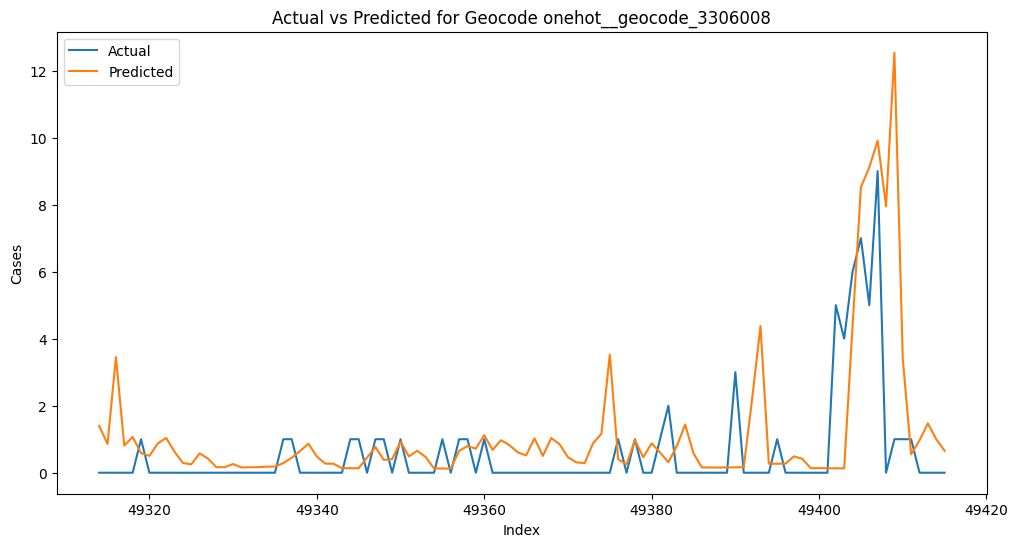

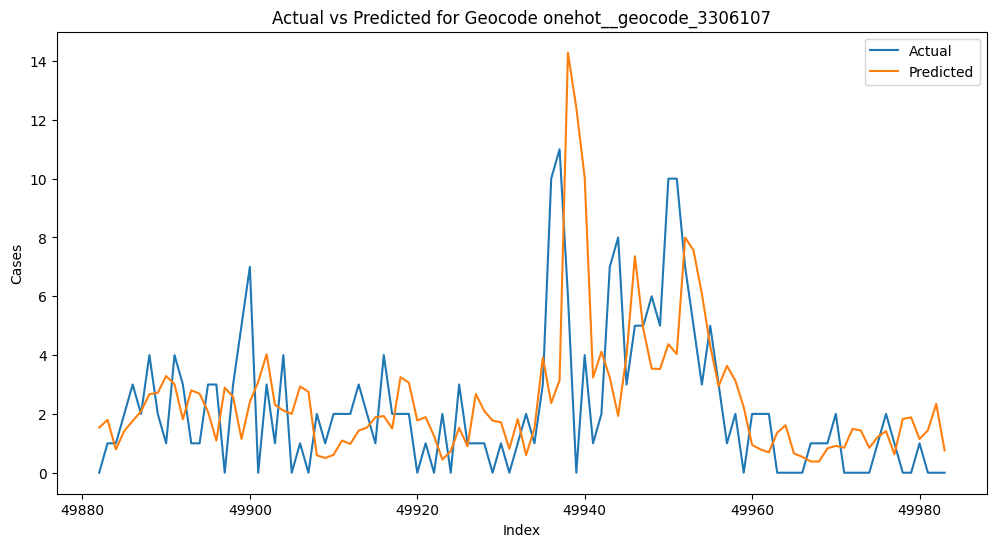

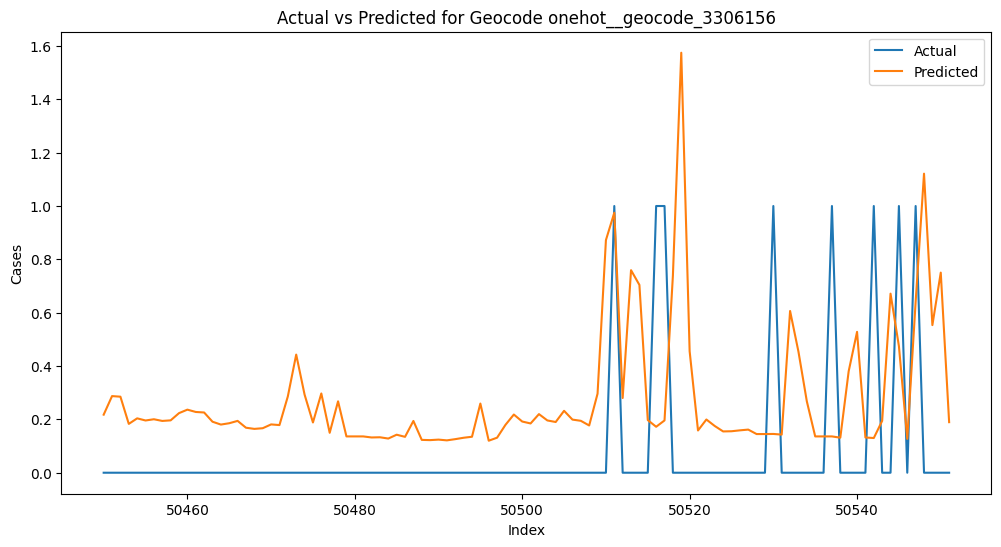

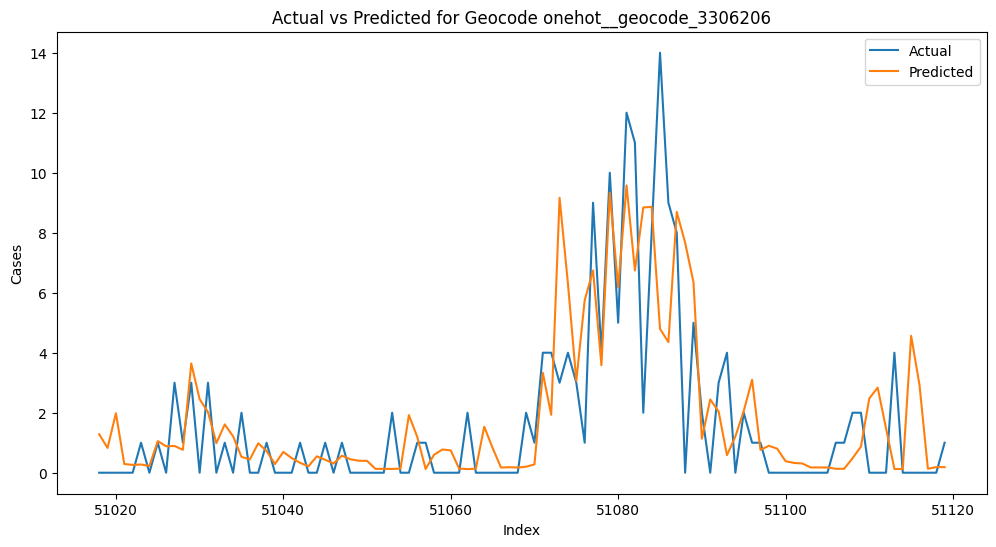

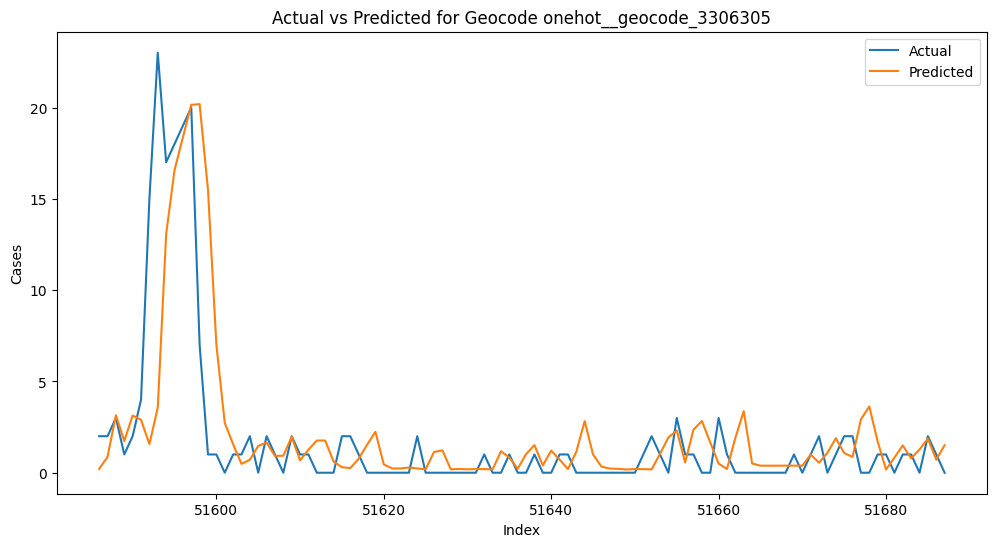

In [40]:
# Define parameter grid for Random Forest
grid_params = {
    'n_estimators': [50],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, grid_params, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train_scaled)

best_model = grid_search.best_estimator_

# Predictions
y_train_pred_scaled = best_model.predict(X_train)
y_test_pred_scaled = best_model.predict(X_test)

y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_train_original = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred))
train_r2 = r2_score(y_train_original, y_train_pred)
test_r2 = r2_score(y_test_original, y_test_pred)

mae = mean_absolute_error(y_test_original, y_test_pred)
mape = mean_absolute_percentage_error(y_test_original, y_test_pred)

# Print best parameters and metrics
print("Best Random Forest Parameters:", grid_search.best_params_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R²:", train_r2)
print("Test R²:", test_r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100, "%")

# Feature Importance
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Prepare test dataframe with results
X_test_df = pd.DataFrame(X_test, columns=selected_columns)
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_test_pred

# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):
        subset = X_test_df[X_test_df[geocode] == 1]
        plt.figure(figsize=(12, 6))
        plt.plot(subset.index, subset["actual"], label='Actual')
        plt.plot(subset.index, subset["predicted"], label='Predicted')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()


In [41]:
# Make a copy of the test DataFrame
X_test_full = X_test.copy()

# --- Step 1: Reconstruct geocode from one-hot encoded columns
geocode_cols = [col for col in X_test_full.columns if col.startswith("onehot__geocode_")]

# Extract the geocode number from the column name where the value is 1
def extract_geocode(row):
    for col in geocode_cols:
        if row[col] == 1:
            return col.split("_")[-1]  # Gets '3300100' from 'onehot__geocode_3300100'
    return None
X_test_full['geocode'] = X_test_full[geocode_cols].apply(extract_geocode, axis=1)
# Drop all onehot columns
onehot_cols = [col for col in X_test_full.columns if col.startswith("onehot")]
X_test_full.drop(columns=onehot_cols, inplace=True)

X_test_full

cases_lag0  cases_lag1  temp_avg  humidity_avg  \
466      0.000068    0.000000  0.751505      0.202532   
467      0.000000    0.000068  0.764861      0.219278   
468      0.000000    0.000000  0.865423      0.120433   
469      0.000000    0.000000  0.878550      0.104945   
470      0.000068    0.000000  0.723372      0.225312   
...           ...         ...       ...           ...   
51683    0.000000    0.000068  0.646176      0.252885   
51684    0.000068    0.000000  0.646689      0.269193   
51685    0.000068    0.000068  0.723409      0.273345   
51686    0.000000    0.000068  0.697390      0.256763   
51687    0.000136    0.000000  0.684211      0.252628   

       precipitation_avg_ordinary_kriging_lag3  \
466                                   0.348628   
467                                   0.618504   
468                                   0.461565   
469                                   0.304426   
470                                   0.359700   
...                                        ...   
51683                                 0.200626   
51684                                 0.340947   
51685                                 0.305778   
51686                                 0.194017   
51687                                 0.283354   

       precipitation_avg_ordinary_kriging_lag4  week_sin     month_sin  \
466                                   0.540021 -0.354605  5.000000e-01   
467                                   0.348628 -0.464723  5.000000e-01   
468                                   0.618504 -0.568065  5.000000e-01   
469                                   0.461565 -0.663123  5.000000e-01   
470                                   0.304426 -0.748511  5.000000e-01   
...                                        ...       ...           ...   
51683                                 0.098343  0.822984 -5.000000e-01   
51684                                 0.200626  0.748511 -5.000000e-01   
51685                                 0.340947  0.663123 -5.000000e-01   
51686                                 0.305778  0.568065 -2.449294e-16   
51687                                 0.194017  0.464723 -2.449294e-16   

       week_cos  month_cos    week  cases_per_100k       vim  geocode  
466   -0.935016   0.866025  202101        0.000223  0.963220  3300100  
467   -0.885456   0.866025  202102        0.000000  0.966169  3300100  
468   -0.822984   0.866025  202103        0.000000  0.969017  3300100  
469   -0.748511   0.866025  202104        0.000000  0.971627  3300100  
470   -0.663123   0.866025  202105        0.000223  0.973972  3300100  
...         ...        ...     ...             ...       ...      ...  
51683 -0.568065   0.866025  202246        0.000000  0.623943  3306305  
51684 -0.663123   0.866025  202247        0.000168  0.655851  3306305  
51685 -0.748511   0.866025  202248        0.000168  0.686303  3306305  
51686 -0.822984   1.000000  202249        0.000000  0.714862  3306305  
51687 -0.885456   1.000000  202250        0.000336  0.740042  3306305  

[9282 rows x 14 columns]

In [42]:
X_test_full['year'] = X_test_full['week'].astype(str).str[:4].astype(int)
X_test_full

cases_lag0  cases_lag1  temp_avg  humidity_avg  \
466      0.000068    0.000000  0.751505      0.202532   
467      0.000000    0.000068  0.764861      0.219278   
468      0.000000    0.000000  0.865423      0.120433   
469      0.000000    0.000000  0.878550      0.104945   
470      0.000068    0.000000  0.723372      0.225312   
...           ...         ...       ...           ...   
51683    0.000000    0.000068  0.646176      0.252885   
51684    0.000068    0.000000  0.646689      0.269193   
51685    0.000068    0.000068  0.723409      0.273345   
51686    0.000000    0.000068  0.697390      0.256763   
51687    0.000136    0.000000  0.684211      0.252628   

       precipitation_avg_ordinary_kriging_lag3  \
466                                   0.348628   
467                                   0.618504   
468                                   0.461565   
469                                   0.304426   
470                                   0.359700   
...                                        ...   
51683                                 0.200626   
51684                                 0.340947   
51685                                 0.305778   
51686                                 0.194017   
51687                                 0.283354   

       precipitation_avg_ordinary_kriging_lag4  week_sin     month_sin  \
466                                   0.540021 -0.354605  5.000000e-01   
467                                   0.348628 -0.464723  5.000000e-01   
468                                   0.618504 -0.568065  5.000000e-01   
469                                   0.461565 -0.663123  5.000000e-01   
470                                   0.304426 -0.748511  5.000000e-01   
...                                        ...       ...           ...   
51683                                 0.098343  0.822984 -5.000000e-01   
51684                                 0.200626  0.748511 -5.000000e-01   
51685                                 0.340947  0.663123 -5.000000e-01   
51686                                 0.305778  0.568065 -2.449294e-16   
51687                                 0.194017  0.464723 -2.449294e-16   

       week_cos  month_cos    week  cases_per_100k       vim  geocode  year  
466   -0.935016   0.866025  202101        0.000223  0.963220  3300100  2021  
467   -0.885456   0.866025  202102        0.000000  0.966169  3300100  2021  
468   -0.822984   0.866025  202103        0.000000  0.969017  3300100  2021  
469   -0.748511   0.866025  202104        0.000000  0.971627  3300100  2021  
470   -0.663123   0.866025  202105        0.000223  0.973972  3300100  2021  
...         ...        ...     ...             ...       ...      ...   ...  
51683 -0.568065   0.866025  202246        0.000000  0.623943  3306305  2022  
51684 -0.663123   0.866025  202247        0.000168  0.655851  3306305  2022  
51685 -0.748511   0.866025  202248        0.000168  0.686303  3306305  2022  
51686 -0.822984   1.000000  202249        0.000000  0.714862  3306305  2022  
51687 -0.885456   1.000000  202250        0.000336  0.740042  3306305  2022  

[9282 rows x 15 columns]

In [43]:

# Add actual and predicted values
X_test_full['actual'] = y_test_original
X_test_full['rf_pred'] = y_test_pred

# Export predictions by year
rf_preds_2021 = X_test_full[X_test_full['year'] == 2021][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2021.to_csv('rf_preds_2021.csv', index=False)

rf_preds_2022 = X_test_full[X_test_full['year'] == 2022][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2022.to_csv('rf_test_preds_2022.csv', index=False)